# Workload Characterization

## Introduction

### Import relevant modules

In [2]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing

# Utilities
import numpy as np
# from tqdm import tnrange
import pickle
import os
from tqdm import tqdm_notebook as tqdmn
# import warnings

In [3]:
%config InlineBackend.figure_format = 'retina'

# High level parameters

## Read data

In [16]:
df_high = pd.read_csv('WC_report_client.csv')
df_high.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect
0,1610622816777,98,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow Low 2-1,text,True,NaN,1968024,135,1,4,http://192.168.56.101/RepubblicaHome.html,49,0,34
1,1610622816777,114,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow High 1-1,text,True,NaN,1968024,135,1,4,http://192.168.56.101/RepubblicaHome.html,49,0,34
2,1610622816777,124,HTTP Request - YouTube Home,200,OK,Thread Group - Fast Low 4-1,text,True,NaN,4159636,132,1,4,http://192.168.56.101/YouTubeHome.html,49,0,34
3,1610622816777,128,HTTP Request - YouTube Home,200,OK,Thread Group - Fast High 3-1,text,True,NaN,4159636,132,1,4,http://192.168.56.101/YouTubeHome.html,49,0,34
4,1610622817197,28,HTTP Request - Wikipedia Home,200,OK,Thread Group - Fast Low 4-2,text,True,NaN,71559,134,2,8,http://192.168.56.101/WikipediaHome.html,25,0,3


In [17]:
print('The dataset contains', df_high.shape[1], 'columns and', df_high.shape[0], 'rows')

The dataset contains 17 columns and 4464 rows


In [18]:
df_high['success'].all()

True

In [19]:
df_high.loc[df_high['threadName'].str.contains('Slow'), 'throughputType'] = 'slow'
df_high.loc[df_high['threadName'].str.contains('Fast'), 'throughputType'] = 'fast'

df_high.loc[df_high['threadName'].str.contains('Low'), 'usersType'] = 'low'
df_high.loc[df_high['threadName'].str.contains('High'), 'usersType'] = 'high'

df_high.loc[df_high['label'].str.contains('Wikipedia'), 'resourceType'] = 'small'
df_high.loc[df_high['label'].str.contains('Repubblica'), 'resourceType'] = 'medium'
df_high.loc[df_high['label'].str.contains('YouTube'), 'resourceType'] = 'large'

df_high.loc[:, 'requestType'] = df_high.loc[:, 'throughputType'] + ' - ' + df_high.loc[:, 'usersType']  + ' - ' + df_high.loc[:, 'resourceType']

df_high.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,...,grpThreads,allThreads,URL,Latency,IdleTime,Connect,throughputType,usersType,resourceType,requestType
0,1610622816777,98,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow Low 2-1,text,True,NaN,1968024,...,1,4,http://192.168.56.101/RepubblicaHome.html,49,0,34,slow,low,medium,slow - low - medium
1,1610622816777,114,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow High 1-1,text,True,NaN,1968024,...,1,4,http://192.168.56.101/RepubblicaHome.html,49,0,34,slow,high,medium,slow - high - medium
2,1610622816777,124,HTTP Request - YouTube Home,200,OK,Thread Group - Fast Low 4-1,text,True,NaN,4159636,...,1,4,http://192.168.56.101/YouTubeHome.html,49,0,34,fast,low,large,fast - low - large
3,1610622816777,128,HTTP Request - YouTube Home,200,OK,Thread Group - Fast High 3-1,text,True,NaN,4159636,...,1,4,http://192.168.56.101/YouTubeHome.html,49,0,34,fast,high,large,fast - high - large
4,1610622817197,28,HTTP Request - Wikipedia Home,200,OK,Thread Group - Fast Low 4-2,text,True,NaN,71559,...,2,8,http://192.168.56.101/WikipediaHome.html,25,0,3,fast,low,small,fast - low - small


## Data analysis

In [21]:
df_high.describe()

,timeStamp,elapsed,responseCode,failureMessage,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
count,4.464000e+03,4464.000000,4464.0,0.0,4.464000e+03,4464.000000,4464.000000,4464.000000,4464.000000,4464.0,4464.000000
mean,1.610623e+12,40.611335,200.0,NaN,2.032144e+06,133.659050,16.403674,59.028450,5.962814,0.0,0.637993
std,8.593761e+04,37.158805,0.0,NaN,1.739132e+06,1.250863,4.912831,5.691237,8.246997,0.0,1.645545
min,1.610623e+12,1.000000,200.0,NaN,7.155800e+04,132.000000,1.000000,1.000000,0.000000,0.0,0.000000
25%,1.610623e+12,10.000000,200.0,NaN,1.586220e+05,132.000000,10.000000,60.000000,2.000000,0.0,0.000000
50%,1.610623e+12,28.000000,200.0,NaN,1.542999e+06,134.000000,20.000000,60.000000,3.000000,0.0,0.000000
75%,1.610623e+12,63.000000,200.0,NaN,4.061363e+06,135.000000,20.000000,60.000000,6.000000,0.0,1.000000
max,1.610623e+12,195.000000,200.0,NaN,5.096468e+06,135.000000,20.000000,60.000000,114.000000,0.0,34.000000


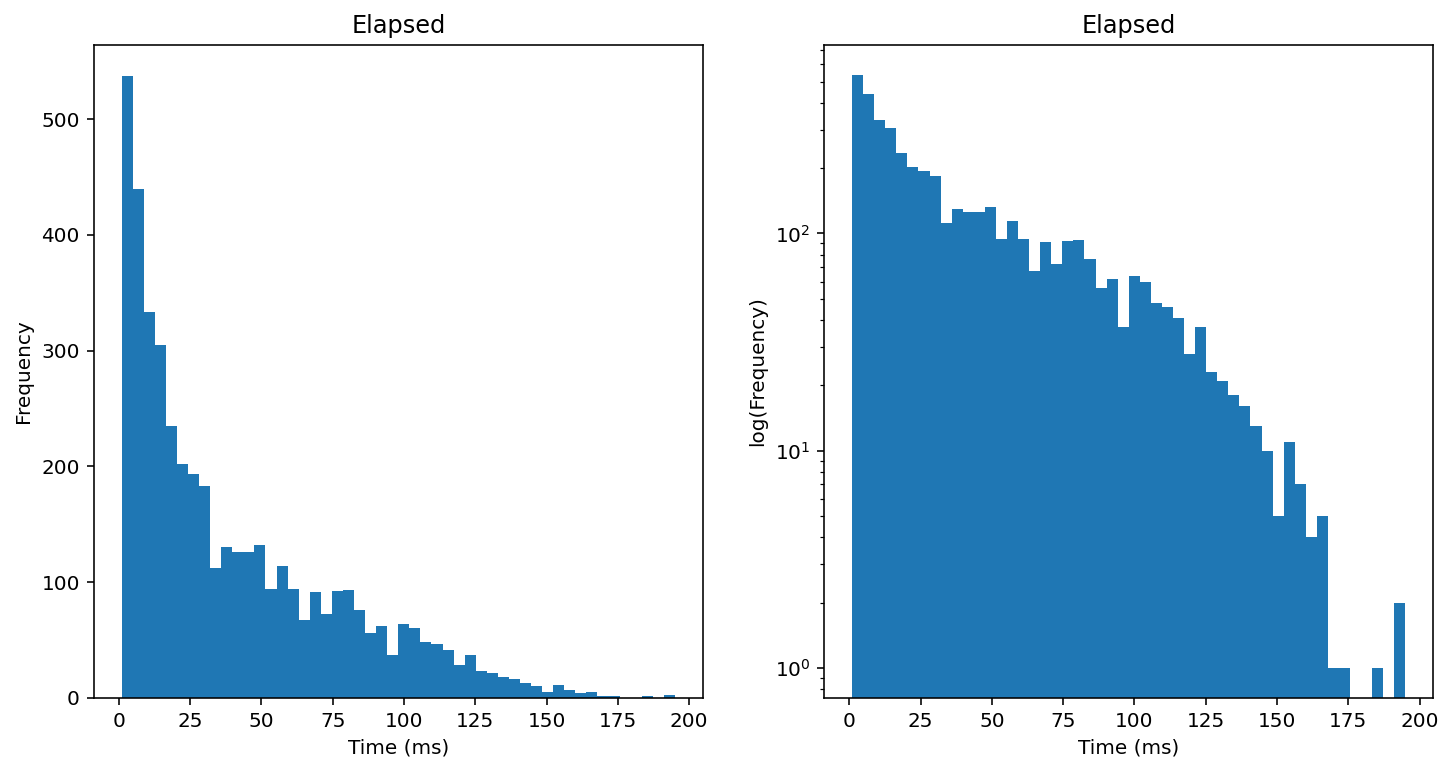

In [22]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.elapsed.plot.hist(bins=50, ax=ax0)
df_high.elapsed.plot.hist(bins=50, ax=ax1)

ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')

ax1.set_title('Elapsed')
ax1.set_ylabel('log(Frequency)')
ax1.set_xlabel('Time (ms)')
ax1.set_yscale('log', nonpositive='clip')

plt.show()

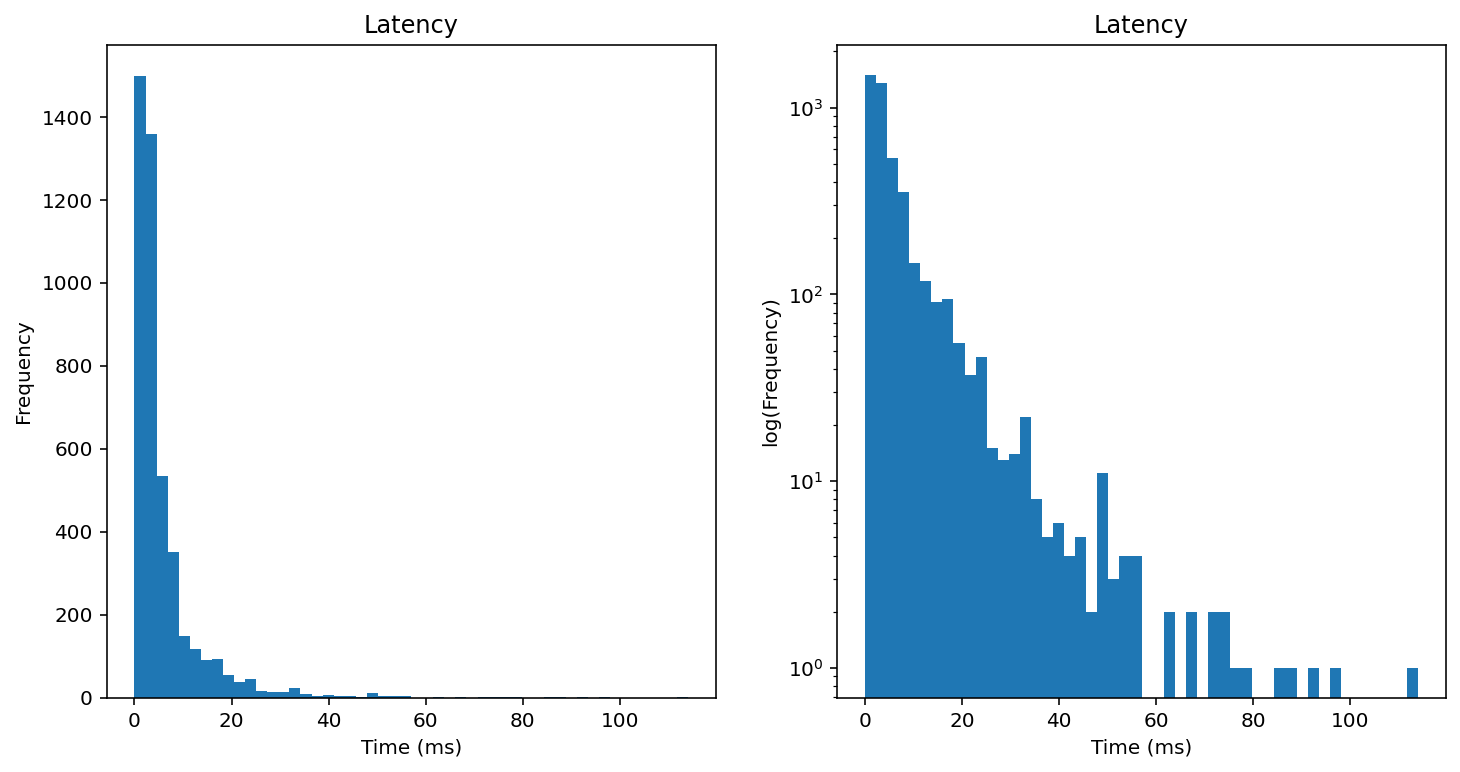

In [23]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.Latency.plot.hist(bins=50, ax=ax0)
df_high.Latency.plot.hist(bins=50, ax=ax1)

ax0.set_title('Latency')
ax0.set_xlabel('Time (ms)')

ax1.set_title('Latency')
ax1.set_ylabel('log(Frequency)')
ax1.set_xlabel('Time (ms)')
ax1.set_yscale('log', nonpositive='clip')

plt.show()

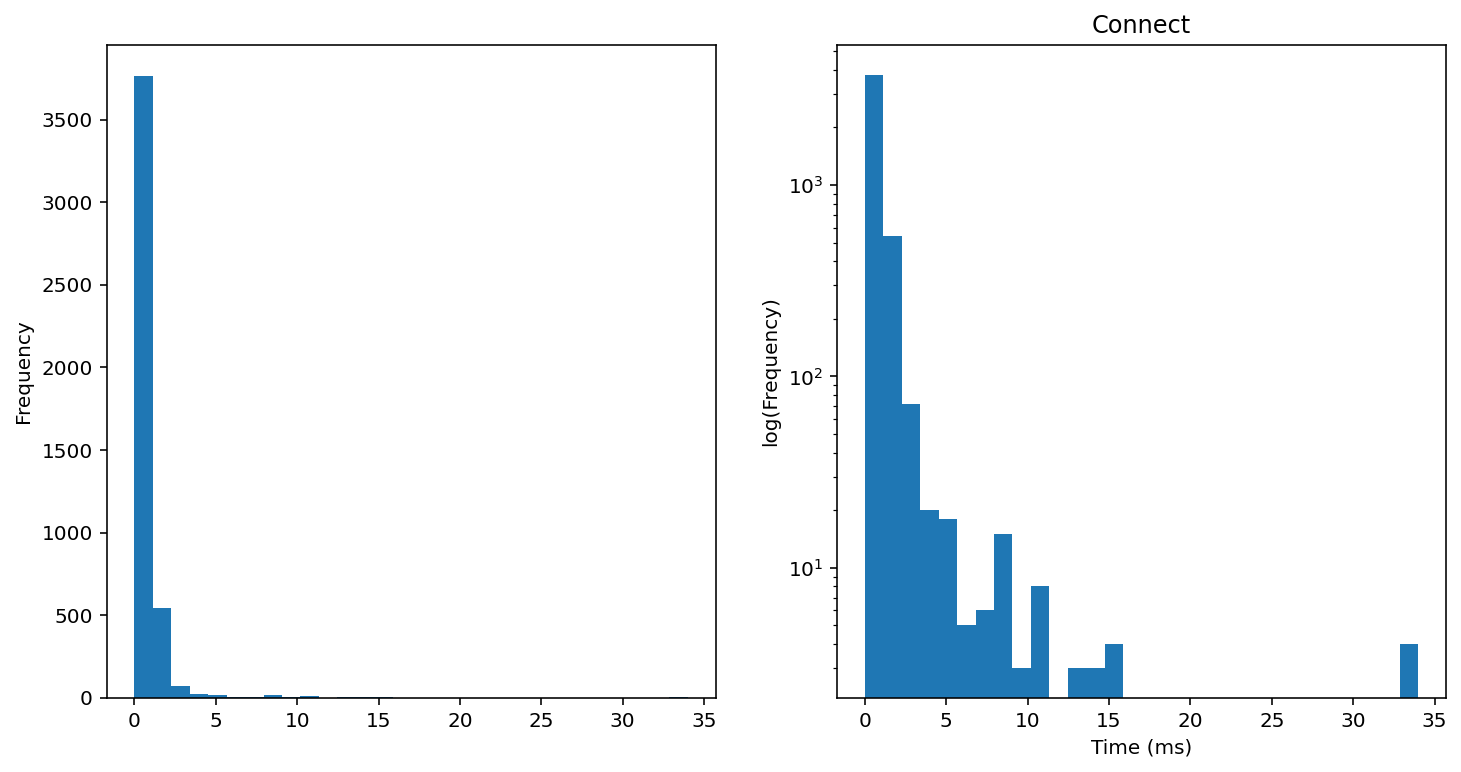

In [24]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.Connect.plot.hist(bins=30, ax=ax0)
df_high.Connect.plot.hist(bins=30, ax=ax1)

ax1.set_title('Connect')
ax1.set_xlabel('Time (ms)')

ax1.set_title('Connect')
ax1.set_ylabel('log(Frequency)')
ax1.set_xlabel('Time (ms)')
ax1.set_yscale('log', nonpositive='clip')

plt.show()

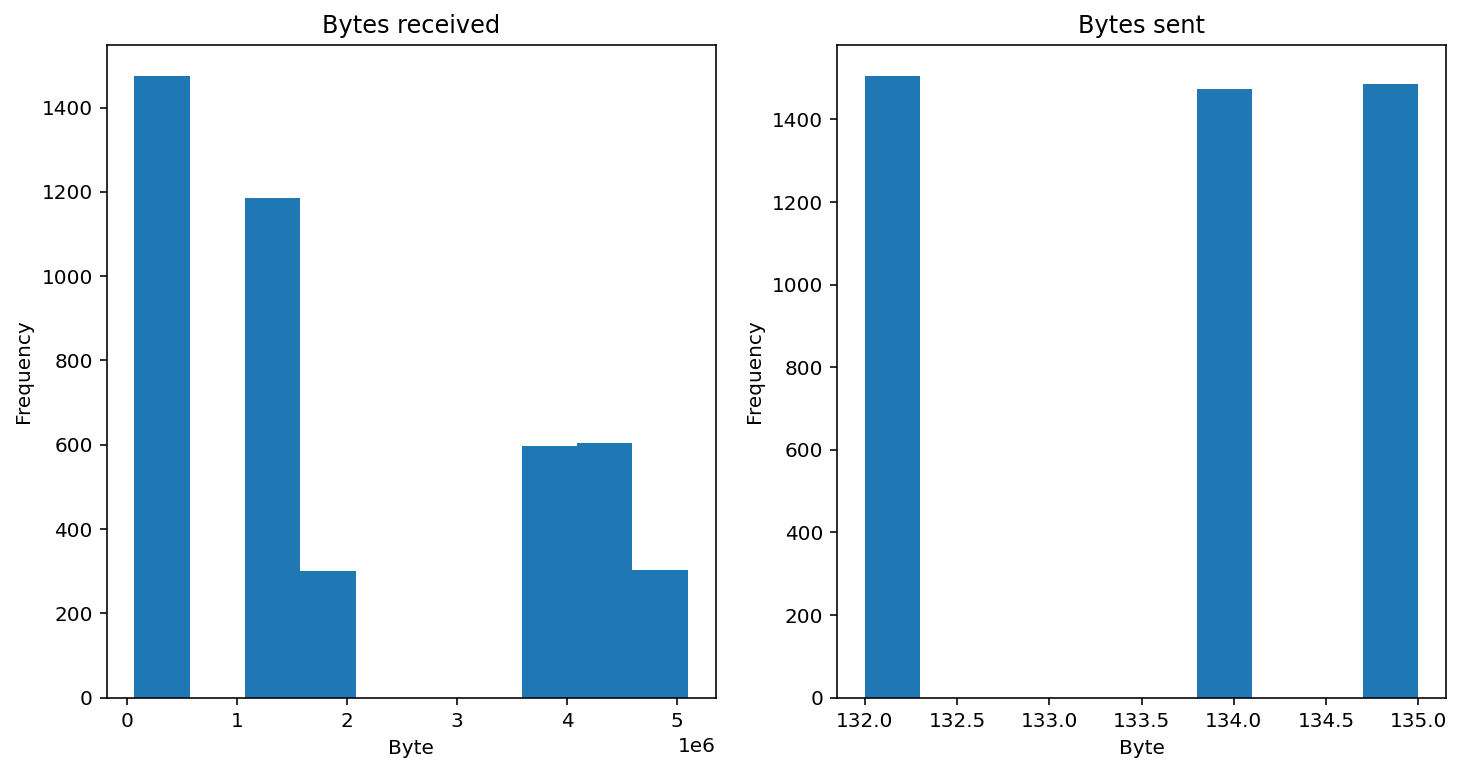

In [26]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.bytes.plot.hist(ax=ax0)
df_high.sentBytes.plot.hist(ax=ax1)

ax0.set_title('Bytes received')
ax0.set_xlabel('Byte')

ax1.set_title('Bytes sent')
ax1.set_xlabel('Byte')

plt.show()

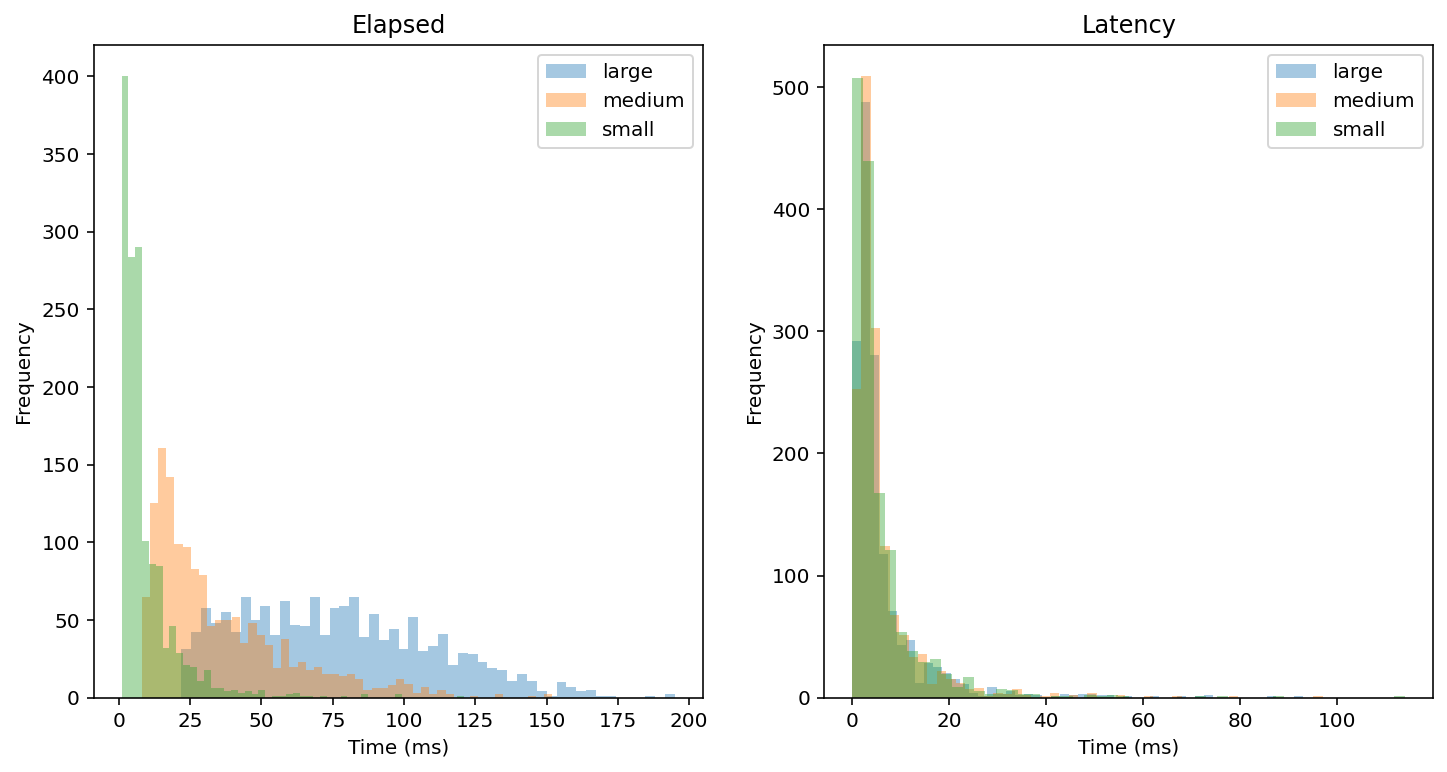

In [33]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.groupby(by='resourceType').elapsed.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax0)
df_high.groupby(by='resourceType').Latency.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax1)

# x_max = df_high.quantile(q=0.99).elapsed
# ax0.set_xlim(-5,x_max)
ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')

# x_max = df_high.quantile(q=0.99).Latency
# ax1.set_xlim(-1,x_max)
ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')

plt.show()

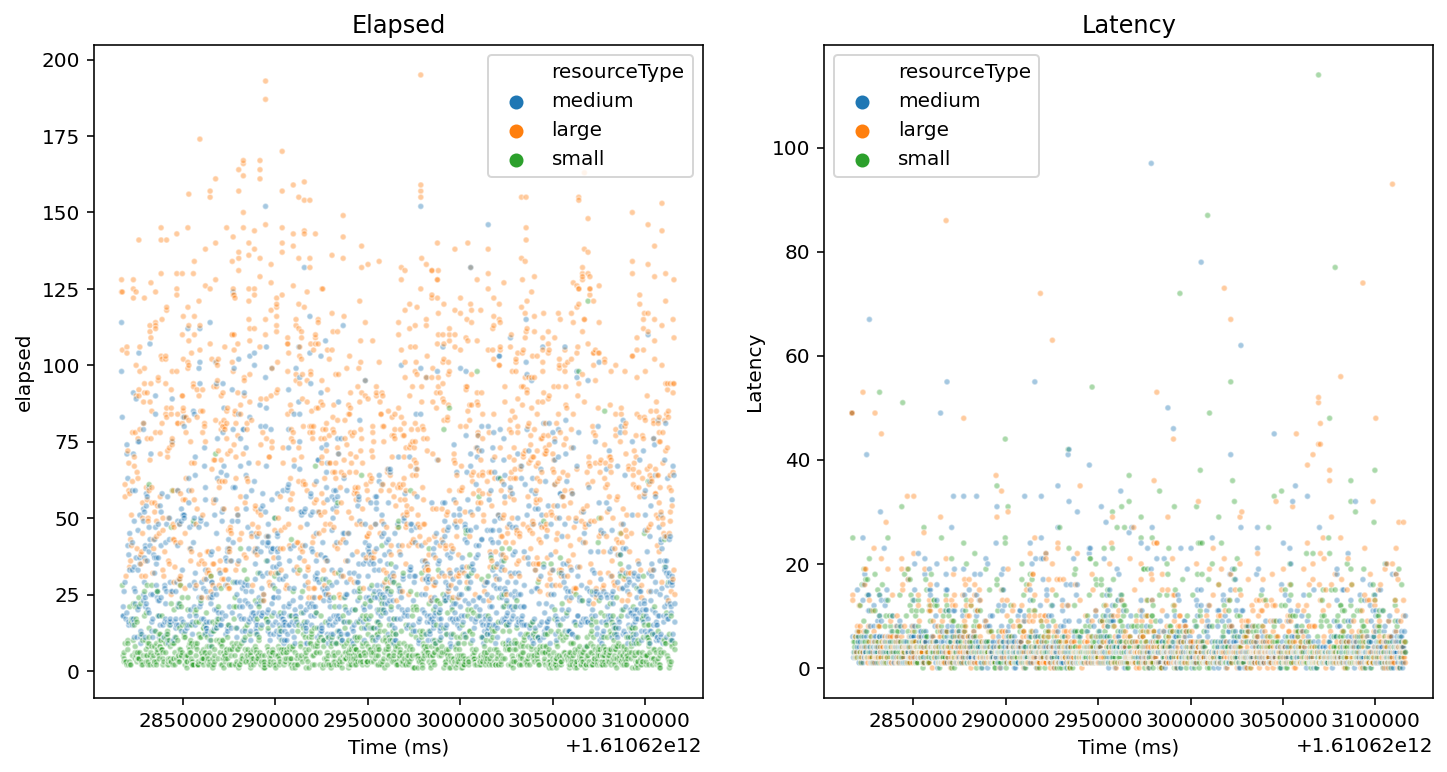

In [28]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

sns.scatterplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, marker='.', alpha=.4, ax=ax0)
sns.scatterplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, marker='.', alpha=.4, ax=ax1)

ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')

ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')

plt.show()

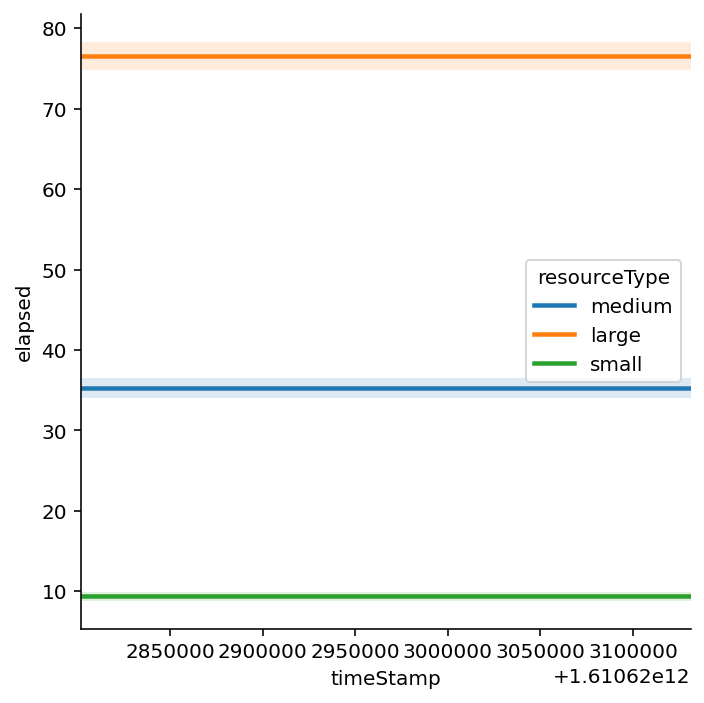

In [29]:
sns.lmplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=5)
plt.show()

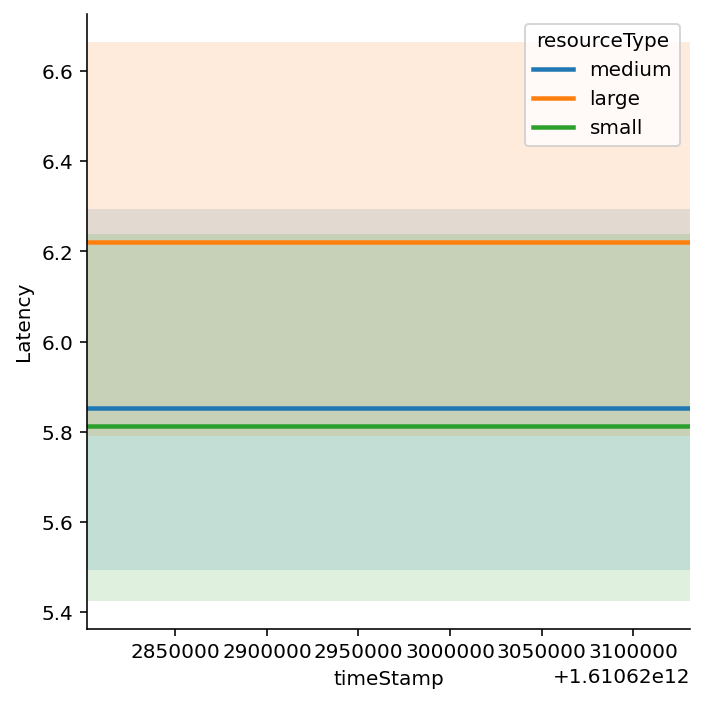

In [30]:
sns.lmplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=5)
plt.show()

### Outlier analysis

In [31]:
q = df_high.quantile(q=0.99)
q

timeStamp         1.610623e+12
elapsed           1.450000e+02
responseCode      2.000000e+02
success           1.000000e+00
failureMessage             NaN
bytes             5.096468e+06
sentBytes         1.350000e+02
grpThreads        2.000000e+01
allThreads        6.000000e+01
Latency           4.300000e+01
IdleTime          0.000000e+00
Connect           7.000000e+00
Name: 0.99, dtype: float64

In [32]:
df_no_outlier = df_high.loc[(df_high['elapsed']<=q['elapsed']) & (df_high['Latency']<=q['Latency']) & (df_high['Connect']<=q['Connect'])]
df_no_outlier.shape

(4346, 21)

In [34]:
df_no_outlier = df_high.copy()

## PCA

### Preprocessing

#### Remove nominal columns

In [170]:
# df_high_pre = df_high.select_dtypes(include=['int64']).copy().drop(columns=['timeStamp', 'grpThreads', 'allThreads', 'Connect', 'Latency'])
df_high_pre = df_no_outlier.select_dtypes(include=['int64']).copy().drop(columns=['timeStamp', 'grpThreads', 'allThreads'])
# df_high_pre = df_no_outlier.select_dtypes(include=['int64']).copy().drop(columns=['timeStamp'])

df_high_pre.head()

,elapsed,responseCode,bytes,sentBytes,Latency,IdleTime,Connect
0,98,200,1968024,135,49,0,34
1,114,200,1968024,135,49,0,34
2,124,200,4159636,132,49,0,34
3,128,200,4159636,132,49,0,34
4,28,200,71559,134,25,0,3


In [172]:
request_type_encoder = preprocessing.LabelEncoder()
request_type_encoder.fit(df_high['requestType'].unique())

df_high_pre['requestType'] = request_type_encoder.transform(df_no_outlier['requestType'])

df_high_pre.head()

,elapsed,responseCode,bytes,sentBytes,Latency,IdleTime,Connect,requestType
0,98,200,1968024,135,49,0,34,10
1,114,200,1968024,135,49,0,34,7
2,124,200,4159636,132,49,0,34,3
3,128,200,4159636,132,49,0,34,0
4,28,200,71559,134,25,0,3,5


#### Remove constant components

In [174]:
df_const = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() == 1]]
df_const.head()

,responseCode,IdleTime
0,200,0
1,200,0
2,200,0
3,200,0
4,200,0


In [175]:
df_high_pre = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() != 1]]
df_high_pre.head()

,elapsed,bytes,sentBytes,Latency,Connect,requestType
0,98,1968024,135,49,34,10
1,114,1968024,135,49,34,7
2,124,4159636,132,49,34,3
3,128,4159636,132,49,34,0
4,28,71559,134,25,3,5


#### Remove perfectly correlated components

In [176]:
df_corr = df_high_pre.corr()
df_corr

,elapsed,bytes,sentBytes,Latency,Connect,requestType
elapsed,1.000000,0.752002,-0.559024,0.291623,0.098535,-0.139945
bytes,0.752002,1.000000,-0.762517,0.020631,0.001038,-0.250944
sentBytes,-0.559024,-0.762517,1.000000,-0.020365,0.007949,0.151386
Latency,0.291623,0.020631,-0.020365,1.000000,0.150577,-0.082001
Connect,0.098535,0.001038,0.007949,0.150577,1.000000,0.387135
requestType,-0.139945,-0.250944,0.151386,-0.082001,0.387135,1.000000


#### Normalize the components

In [177]:
x = df_high_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_high_pre = pd.DataFrame(data=x_scaled, columns=df_high_pre.columns)
df_high_pre.head()

,elapsed,bytes,sentBytes,Latency,Connect,requestType
0,1.544589,-0.036873,1.072139,5.219113,20.276407,1.828831
1,1.975222,-0.036873,1.072139,5.219113,20.276407,0.913800
2,2.244367,1.223443,-1.326473,5.219113,20.276407,-0.306240
3,2.352025,1.223443,-1.326473,5.219113,20.276407,-1.221270
4,-0.339428,-1.127462,0.272602,2.308637,1.435556,0.303780


### Perform PCA

In [179]:
pca = PCA()

princ_comp = pca.fit(df_high_pre.values)

In [180]:
d = pca.transform(df_high_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_high_pca = pd.DataFrame(data=d, columns=c)
df_high_pca.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5
0,0.377969,17.664103,3.111603,11.078937,-0.810725,-0.086367
1,0.811543,17.197020,3.499068,11.630136,-0.555468,0.225828
2,3.249814,16.528741,3.108991,12.219897,-1.964903,0.382130
3,3.506503,16.004409,3.462307,12.816695,-1.915522,0.539031
4,-0.766289,1.834498,2.043895,0.214875,-0.846276,0.226171


#### Explained variance

In [181]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA.head(10)

,explained variance,explained variance ratio,cumulative explained variance ratio
0,2.483079,0.413754,0.413754
1,1.397226,0.232819,0.646573
2,1.050969,0.175122,0.821695
3,0.542434,0.090385,0.912080
4,0.382455,0.063728,0.975808
5,0.145182,0.024192,1.000000


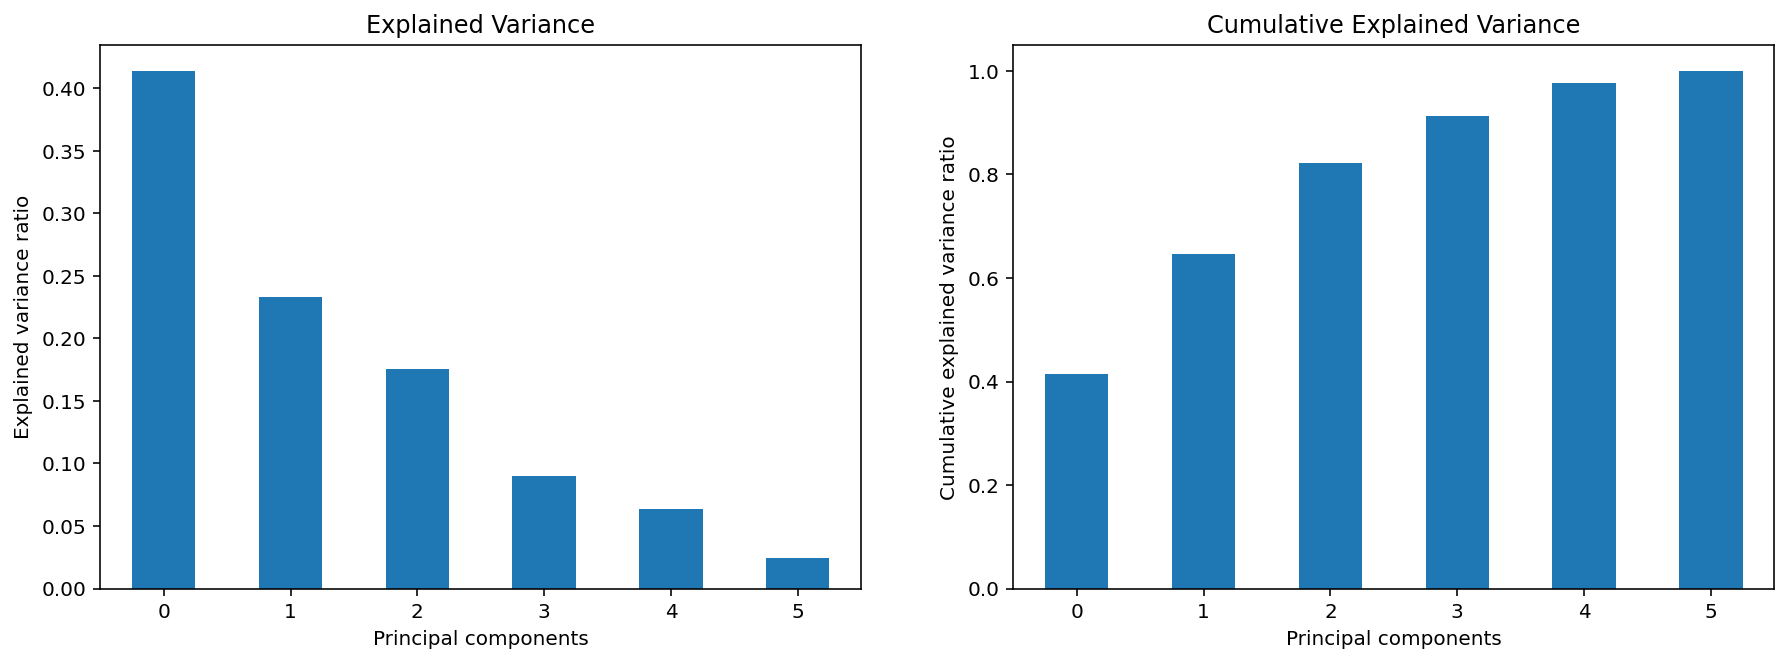

In [182]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.tick_params(labelrotation=0)
ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.tick_params(labelrotation=0)
ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
plt.show()

## Clustering

### Select principal components

In [183]:
dev_tot = df_high_pre.sub(df_high_pre.mean()).pow(2).sum().sum()

nmin_comp = 3
nmax_comp = 5
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 50

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
filepath = './array_dev_lost.txt'
if(not os.path.isfile(filepath)):
    print('Creating file',filepath, 'this may take a while...\n')
    
    array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
    
    for i in tqdmn(range(nmin_comp, nmax_comp+1), desc='outer loop'):

        for j in tqdmn(range(1, nmax_cluster+1), desc='inner loop'):
            df_clustering = df_high_pca.iloc[:,0:i]

            # clustering
            clustering = AgglomerativeClustering(n_clusters=j)
            clustering = clustering.fit(df_clustering.values)

            df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

            # deviance PCA
            df_pca = df_high_pca.iloc[:,0:i]
            dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

            # deviance clustering 
            n_elem = df_clustering.groupby('cluster').count().values[:,0]
            centroids = df_clustering.groupby('cluster').mean()

            # intra-cluster deviance
            arr = np.zeros(shape=(j,1))
            for k in range(j):
                elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
                arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
            dev_intra = arr.sum()

            # inter-cluster deviance
            dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
            dev_inter

            # deviance lost
            dev_pca_ratio = dev_pca/dev_tot
            dev_inter_ratio = dev_inter/dev_pca
            dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

            array_dev_lost[j-1][i-n_comp] = dev_lost
            
#             print(array_dev_lost)
    with open (filepath, 'wb') as fp:
        pickle.dump(array_dev_lost, fp)

else:
    print('File already exists!\n')
    with open (filepath, 'rb') as fp:
        array_dev_lost = pickle.load(fp)
        
        
# array_dev_lost

Creating file ./array_dev_lost.txt this may take a while...



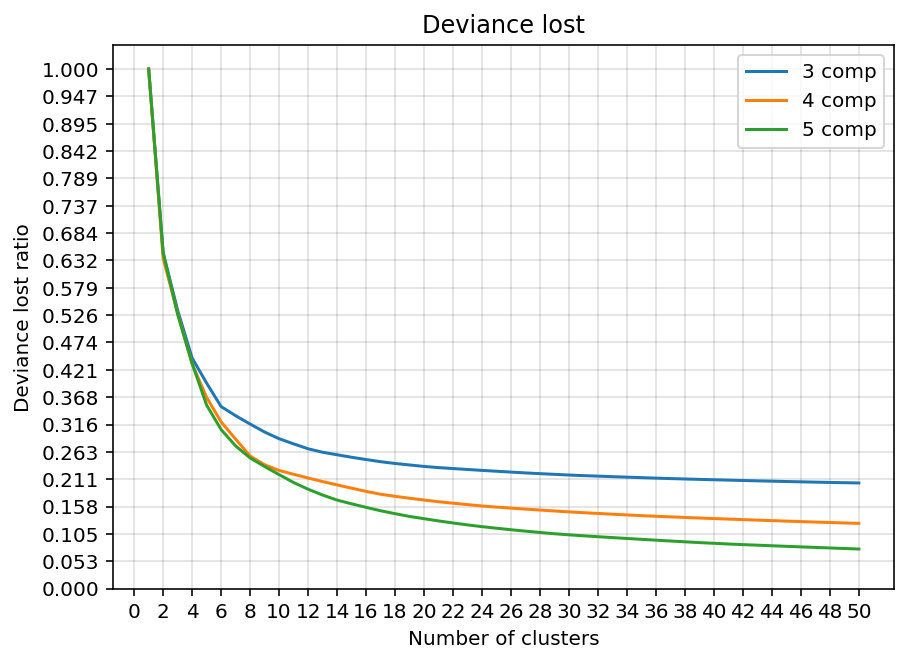

In [184]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0,nmax_cluster+1,2))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)
plt.show()

In [30]:
# 4 - 8
# 4 - 10
# 3 - 8 -> bella

In [246]:
n_comp = 4
df_high_to_cluster = df_high_pca.iloc[:,0:n_comp]
df_high_to_cluster.head()

,comp 0,comp 1,comp 2,comp 3
0,0.377969,17.664103,3.111603,11.078937
1,0.811543,17.197020,3.499068,11.630136
2,3.249814,16.528741,3.108991,12.219897
3,3.506503,16.004409,3.462307,12.816695
4,-0.766289,1.834498,2.043895,0.214875


### Perform clustering

In [247]:
n_clusters = 10

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering = clustering.fit(df_high_to_cluster.values)

In [248]:
df_high_clustered = df_no_outlier.copy()
df_high_clustered.loc[:,'cluster'] = clustering.labels_
df_high_clustered.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,...,allThreads,URL,Latency,IdleTime,Connect,throughputType,usersType,resourceType,requestType,cluster
0,1610622816777,98,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow Low 2-1,text,True,NaN,1968024,...,4,http://192.168.56.101/RepubblicaHome.html,49,0,34,slow,low,medium,slow - low - medium,7
1,1610622816777,114,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow High 1-1,text,True,NaN,1968024,...,4,http://192.168.56.101/RepubblicaHome.html,49,0,34,slow,high,medium,slow - high - medium,7
2,1610622816777,124,HTTP Request - YouTube Home,200,OK,Thread Group - Fast Low 4-1,text,True,NaN,4159636,...,4,http://192.168.56.101/YouTubeHome.html,49,0,34,fast,low,large,fast - low - large,7
3,1610622816777,128,HTTP Request - YouTube Home,200,OK,Thread Group - Fast High 3-1,text,True,NaN,4159636,...,4,http://192.168.56.101/YouTubeHome.html,49,0,34,fast,high,large,fast - high - large,7
4,1610622817197,28,HTTP Request - Wikipedia Home,200,OK,Thread Group - Fast Low 4-2,text,True,NaN,71559,...,8,http://192.168.56.101/WikipediaHome.html,25,0,3,fast,low,small,fast - low - small,6


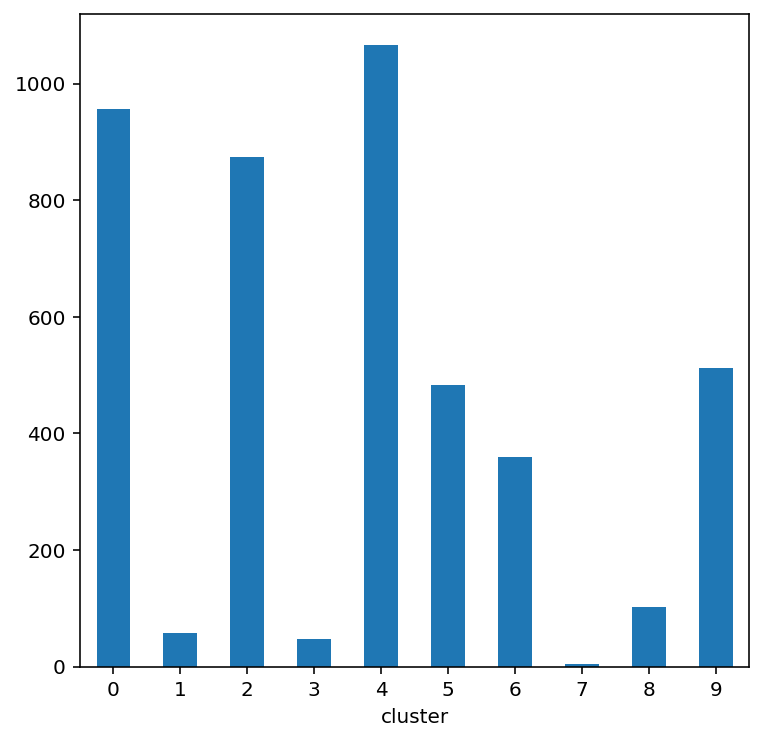

In [249]:
df_high_clustered.groupby(by='cluster').count().timeStamp.plot.bar(figsize=(6,6))
plt.xticks(rotation=0)
plt.show()

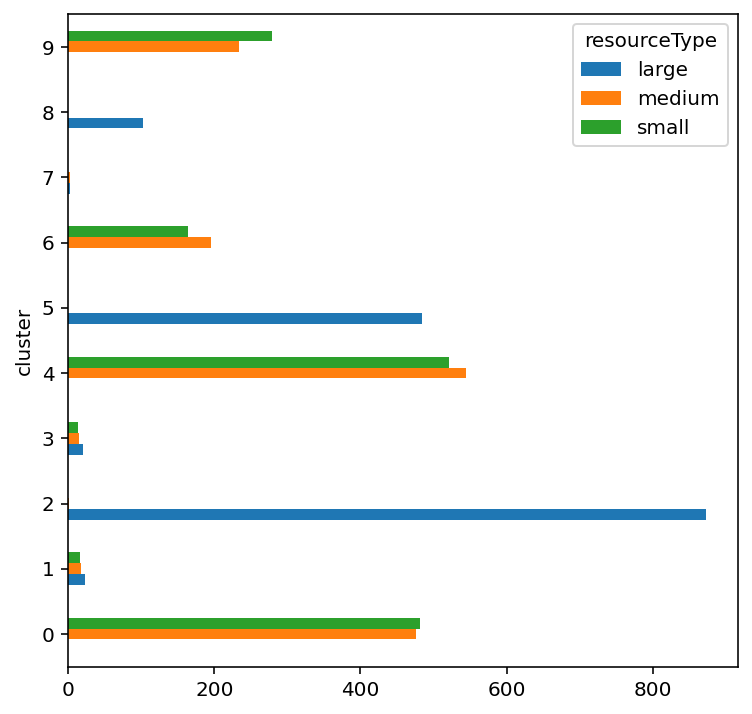

In [250]:
df_high_clustered.groupby(by=['cluster','resourceType']).count().timeStamp.unstack(1).plot.barh(figsize=(6,6))
plt.show()

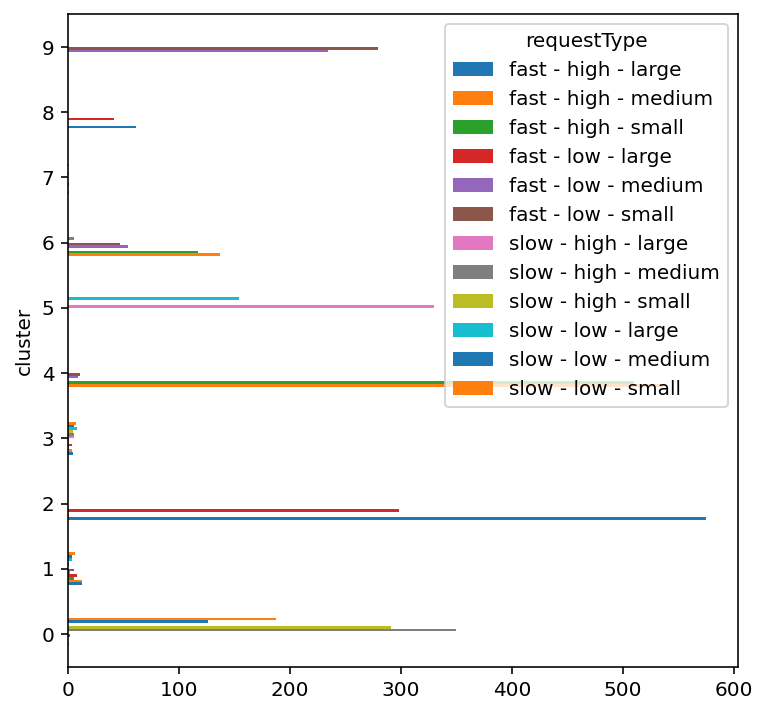

In [251]:
df_high_clustered.groupby(by=['cluster','requestType']).count().timeStamp.unstack(1).plot.barh(figsize=(6,6))
plt.show()

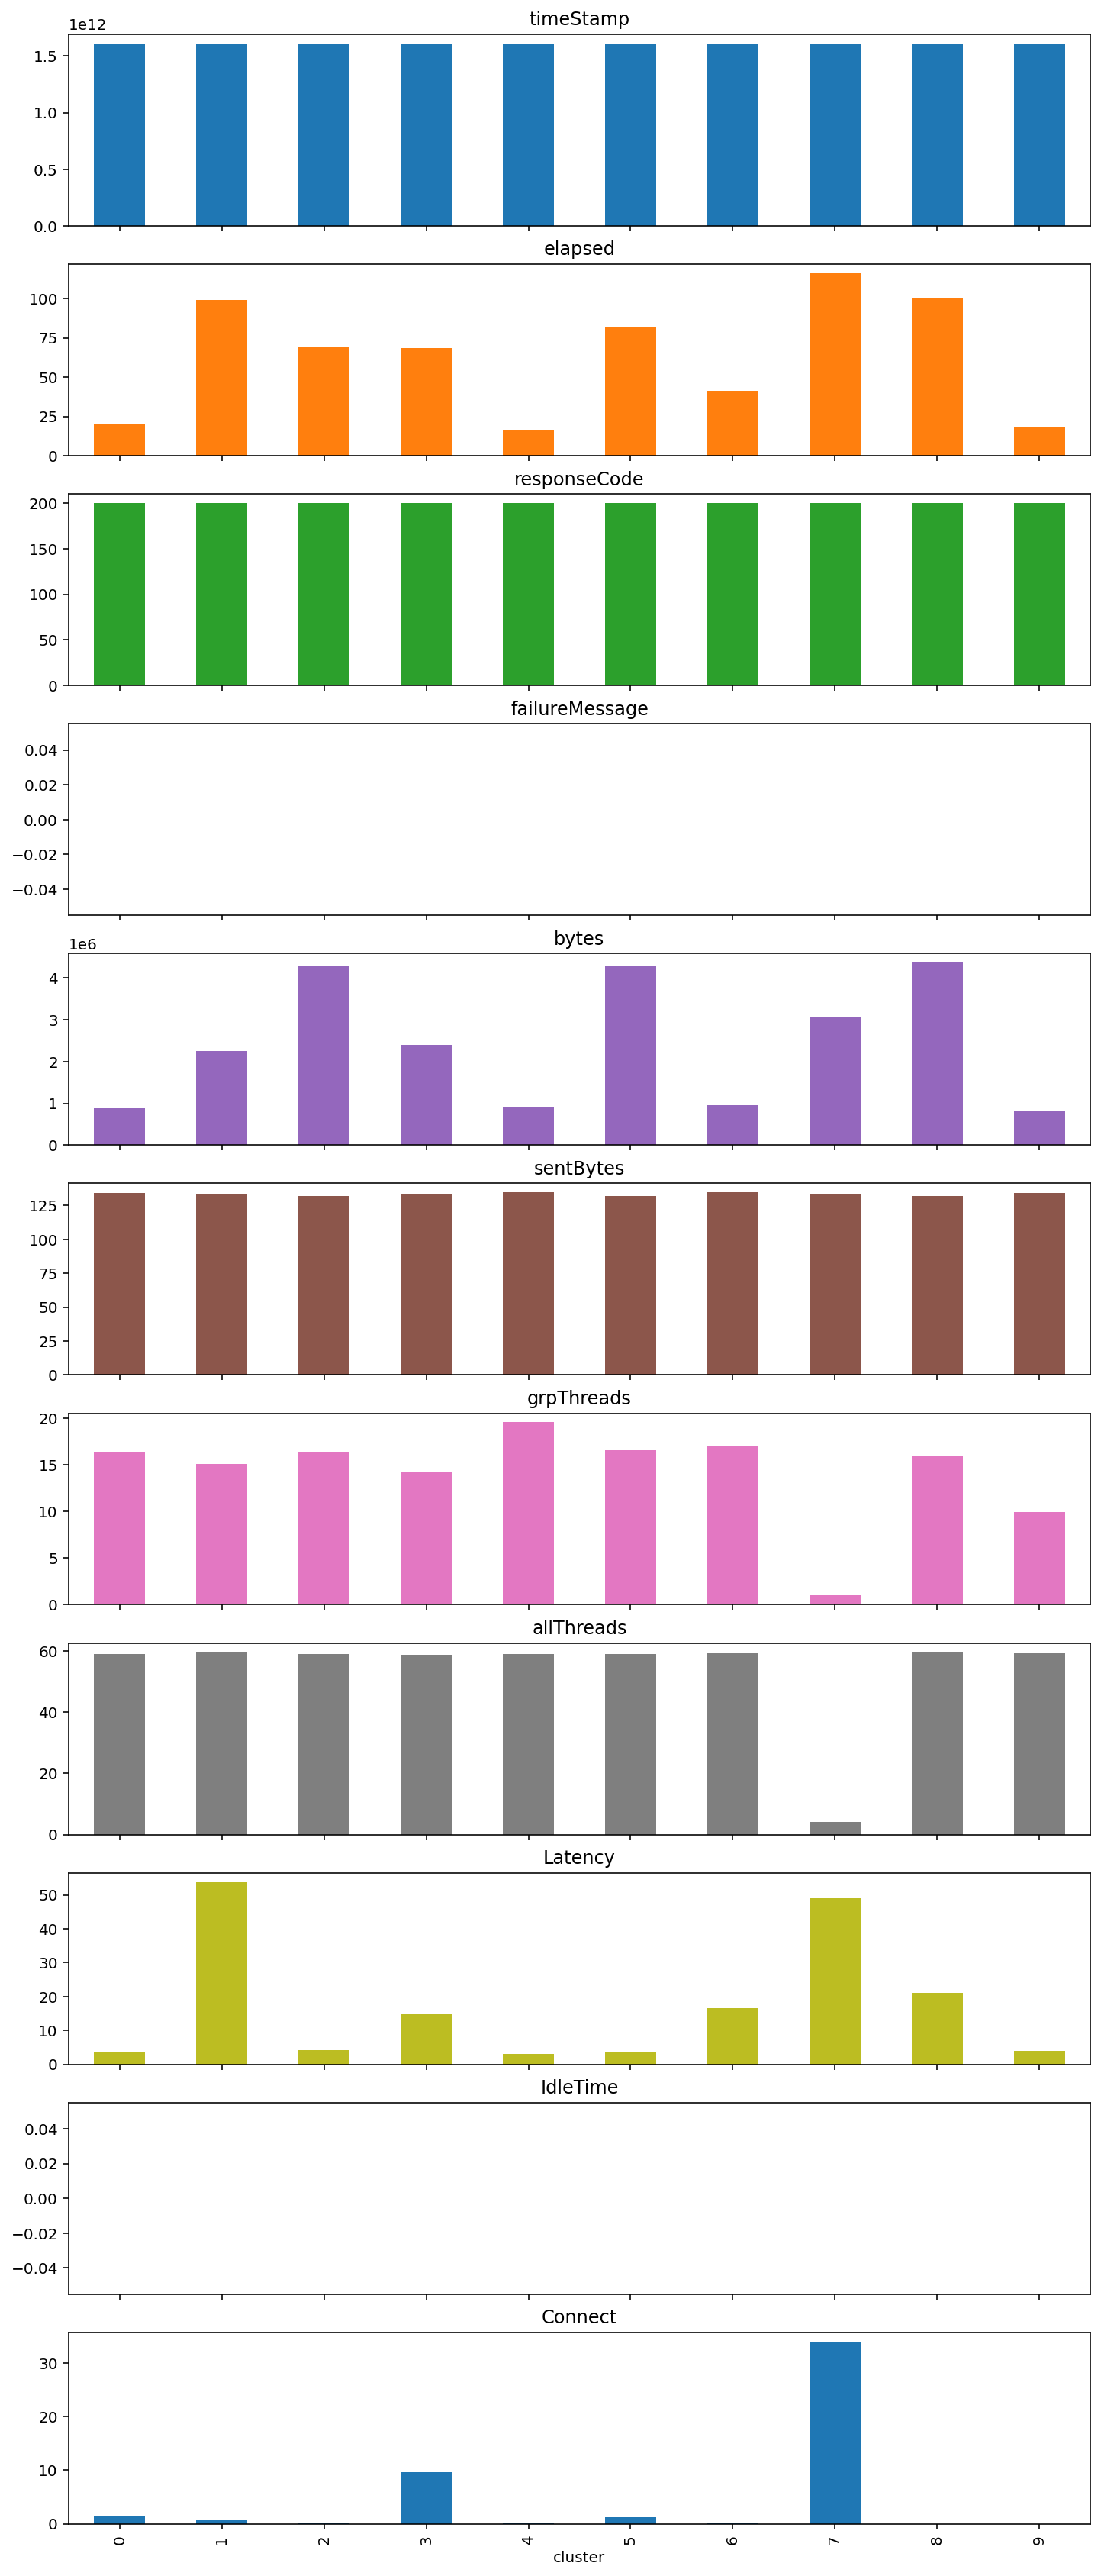

In [252]:
# codice per capire come veniva effettuato il clustering
# df_high_clustered.groupby(by=['cluster','resourceType']).describe()['Latency']
# df_high_clustered.groupby(by=['cluster','resourceType']).describe()['Connect']
df_high_clustered.groupby(by='cluster').mean().plot(kind='bar', subplots=True, figsize=(12,30), legend=False)
plt.show()

## Synthetic workload

In [38]:
# df_high_clustered.groupby(by=['cluster','requestType']).count()

In [39]:
# df_high_clustered.groupby(by=['cluster','requestType']).count().max(level=[0,1])

In [54]:
synthetic_workload = {}

for i in range(n_clusters):
    df_cluster = df_high_clustered.groupby(by=['cluster']).get_group(i)
    requestType = df_cluster.groupby(by=['requestType']).count().timeStamp.sort_values(ascending=False).index[0]
    df_type = df_cluster.groupby(by=['requestType']).get_group(requestType)
    request = df_type.groupby(by=['label']).count().timeStamp.sort_values(ascending=False).index[0]
    synthetic_workload[i] = (requestType,request)

synthetic_workload
# Nota: il cluster 5 risulta poco denso, pertanto non viene considerato nel seguito

{0: ('fast - large', 'HTTP Request - YouTube Pag4'),
 1: ('fast - medium', 'HTTP Request - Repubblica Pag4'),
 2: ('slow - large', 'HTTP Request - YouTube Pag3'),
 3: ('slow - medium', 'HTTP Request - Repubblica Pag2'),
 4: ('fast - medium', 'HTTP Request - Repubblica Pag1'),
 5: ('slow - medium', 'HTTP Request - Repubblica Home')}

In [41]:
# df_synth = df_high_clu.groupby('cluster').apply(lambda x: x.sample())
# df_synth = df_synth.reset_index(level=0, col_level=2 , drop=True)
# df_synth

# Low level parameters

## Read data

In [42]:
df_low = pd.read_csv('WC_report_server.csv', sep='\s+', skiprows=1)
df_low.rename(columns={'r':'procs_r', 'b':'procs_b',
                       'swpd':'memory_swpd', 'free':'memory_free', 'buff':'memory_buff', 'cache':'memory_cache', 
                       'si':'swap_si', 'so':'swap_so', 
                       'bi':'io_bi', 'bo':'io_bo',
                       'in':'system_in', 'cs':'system_cs',
                       'us':'cpu_us', 'sy':'cpu_sy', 'id':'cpu_id', 'wa':'cpu_wa', 'st':'cpu_st'
                      }, inplace=True)
df_low.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
0,4,0,270080,944412,32300,533824,7,41,237,235,379,1449,22,4,73,1,0
1,0,0,270080,943648,32300,533932,0,0,0,0,118,1273,12,3,85,0,0
2,0,0,270080,943648,32300,533932,0,0,0,0,45,111,0,1,99,0,0
3,0,0,270080,943648,32300,533932,0,0,0,0,34,89,0,0,100,0,0
4,0,0,270080,943648,32300,533932,0,0,0,0,49,117,1,0,99,0,0


In [43]:
print('The dataset contains', df_low.shape[1], 'columns and', df_low.shape[0], 'rows')

The dataset contains 17 columns and 310 rows


## Data analysis

In [44]:
df_low.describe()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
count,310.000000,310.0,310.0,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0
mean,0.861290,0.0,270080.0,939953.741935,32581.212903,534694.116129,0.022581,0.132258,0.945161,15.248387,4328.161290,455.438710,1.832258,26.696774,71.216129,0.148387,0.0
std,1.614092,0.0,0.0,3371.968775,162.677833,416.454646,0.397573,2.328644,13.821337,64.647861,1191.798108,131.371756,1.877544,7.165518,7.163039,0.615796,0.0
min,0.000000,0.0,270080.0,924640.000000,32300.000000,533824.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30.000000,0.000000,0.000000,53.000000,0.000000,0.0
25%,0.000000,0.0,270080.0,939363.000000,32452.000000,534456.000000,0.000000,0.000000,0.000000,0.000000,3828.250000,402.000000,1.000000,24.000000,67.000000,0.000000,0.0
50%,0.000000,0.0,270080.0,940740.000000,32596.000000,534744.000000,0.000000,0.000000,0.000000,0.000000,4440.000000,443.500000,1.000000,28.000000,70.000000,0.000000,0.0
75%,1.000000,0.0,270080.0,941496.000000,32724.000000,535036.000000,0.000000,0.000000,0.000000,3.000000,5086.250000,493.500000,2.000000,31.000000,74.000000,0.000000,0.0
max,7.000000,0.0,270080.0,944412.000000,32844.000000,535320.000000,7.000000,41.000000,237.000000,888.000000,6847.000000,1449.000000,22.000000,42.000000,100.000000,6.000000,0.0


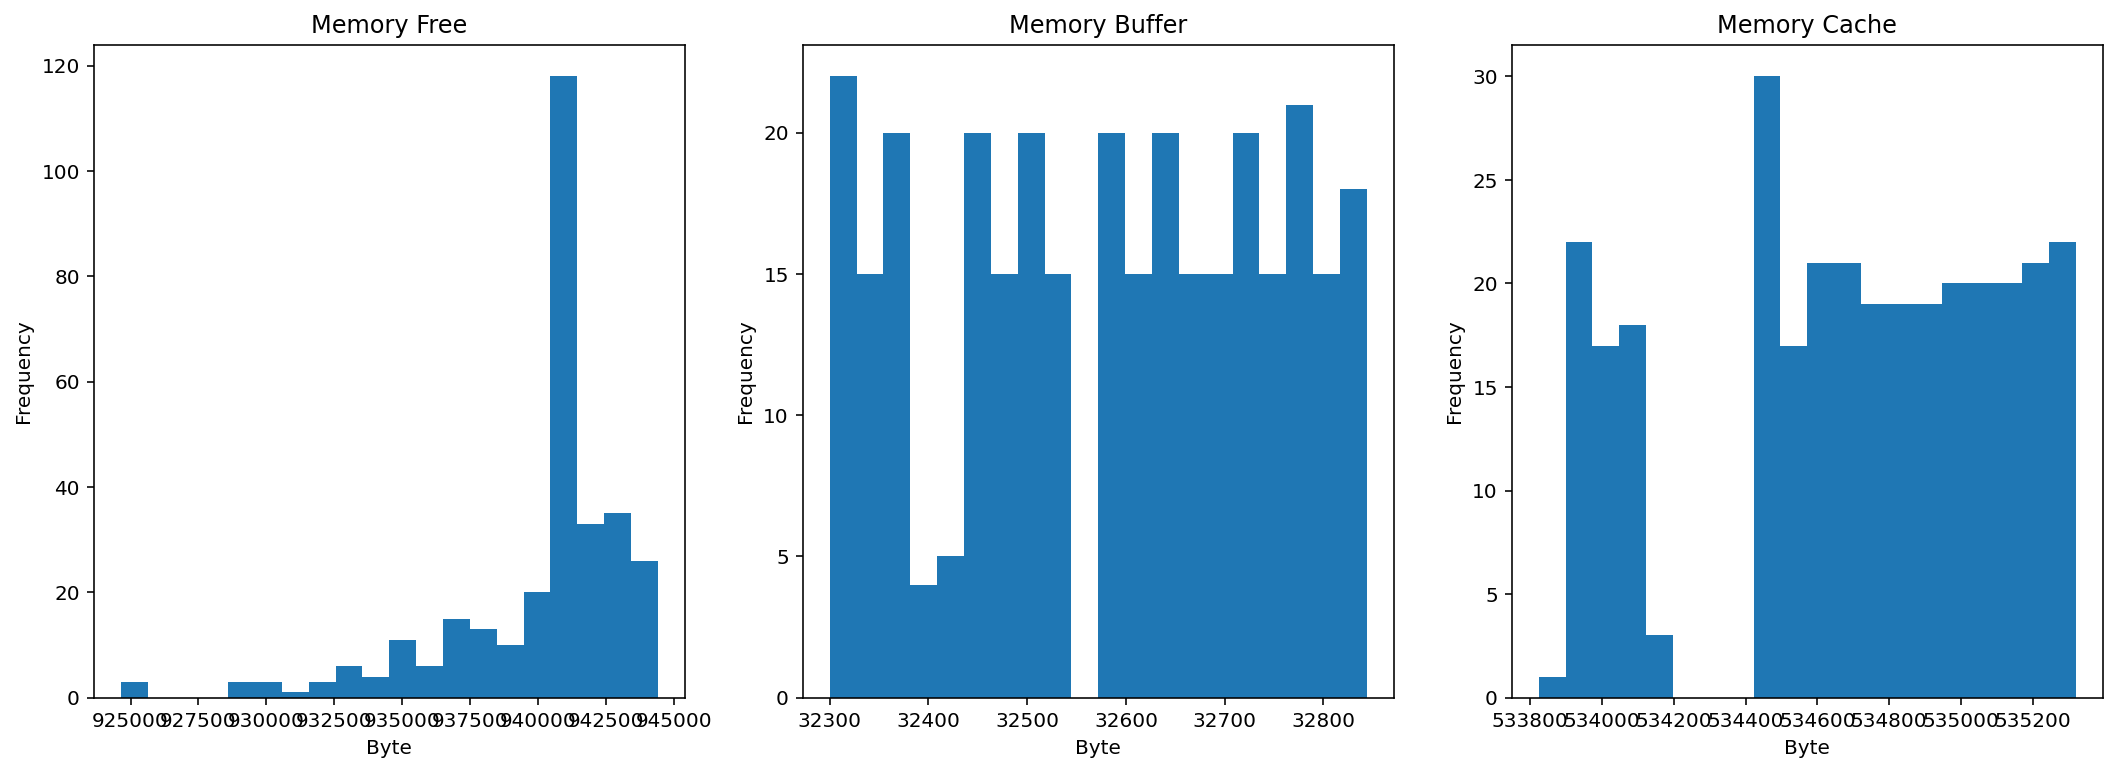

In [57]:
fig = plt.figure(figsize=(18,6))

ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)

df_low.memory_free.plot.hist(bins=20, ax=ax0)
df_low.memory_buff.plot.hist(bins=20, ax=ax1)
df_low.memory_cache.plot.hist(bins=20, ax=ax2)

ax0.set_title('Memory Free')
ax0.set_xlabel('Byte')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed), 5))

ax1.set_title('Memory Buffer')
ax1.set_xlabel('Byte')
# ax1.set_xticks(np.arange(0, max(df_high.Latency), 5))

ax2.set_title('Memory Cache')
ax2.set_xlabel('Byte')

plt.show()

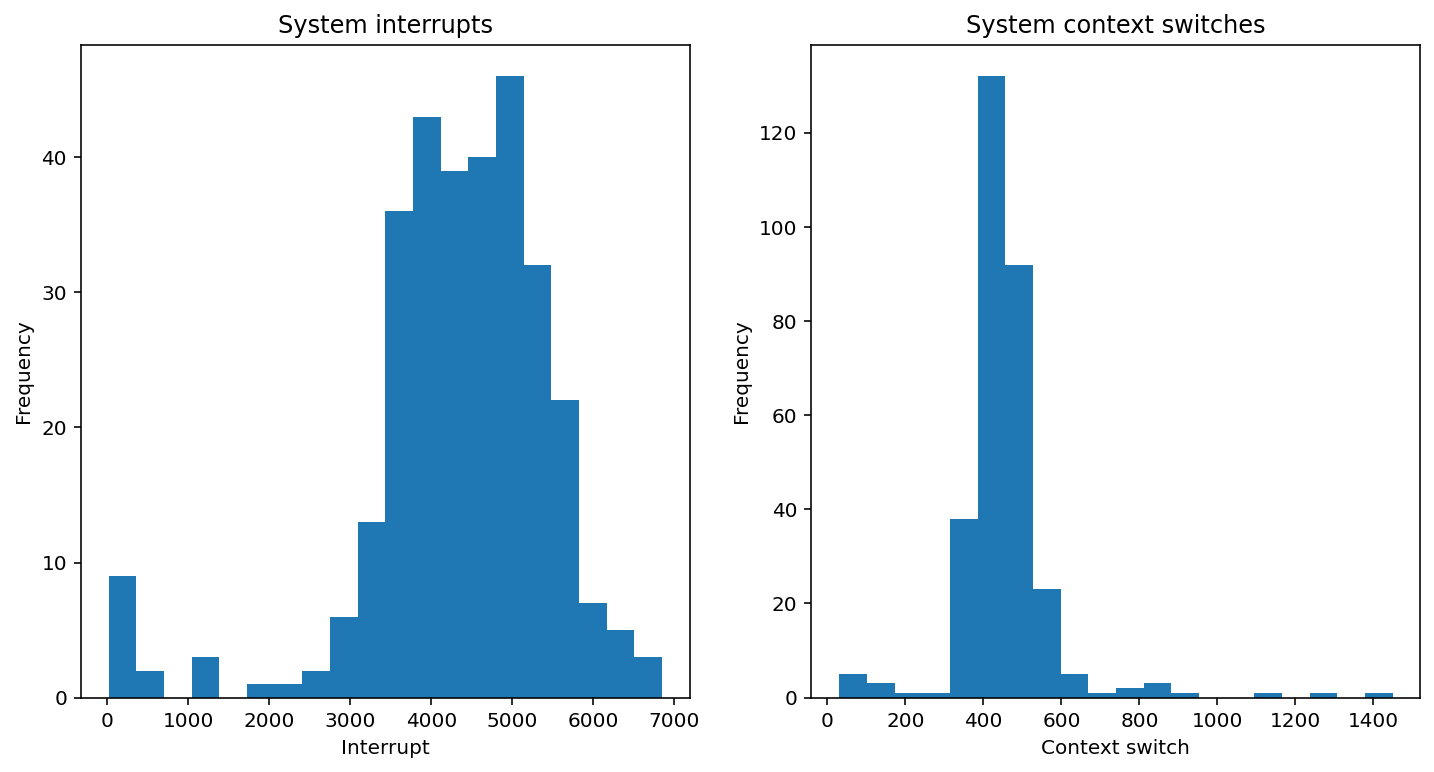

In [46]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_low.system_in.plot.hist(bins=20, ax=ax0)
df_low.system_cs.plot.hist(bins=20, ax=ax1)

ax0.set_title('System interrupts')
ax0.set_xlabel('Interrupt')

ax1.set_title('System context switches')
ax1.set_xlabel('Context switch')

plt.show()

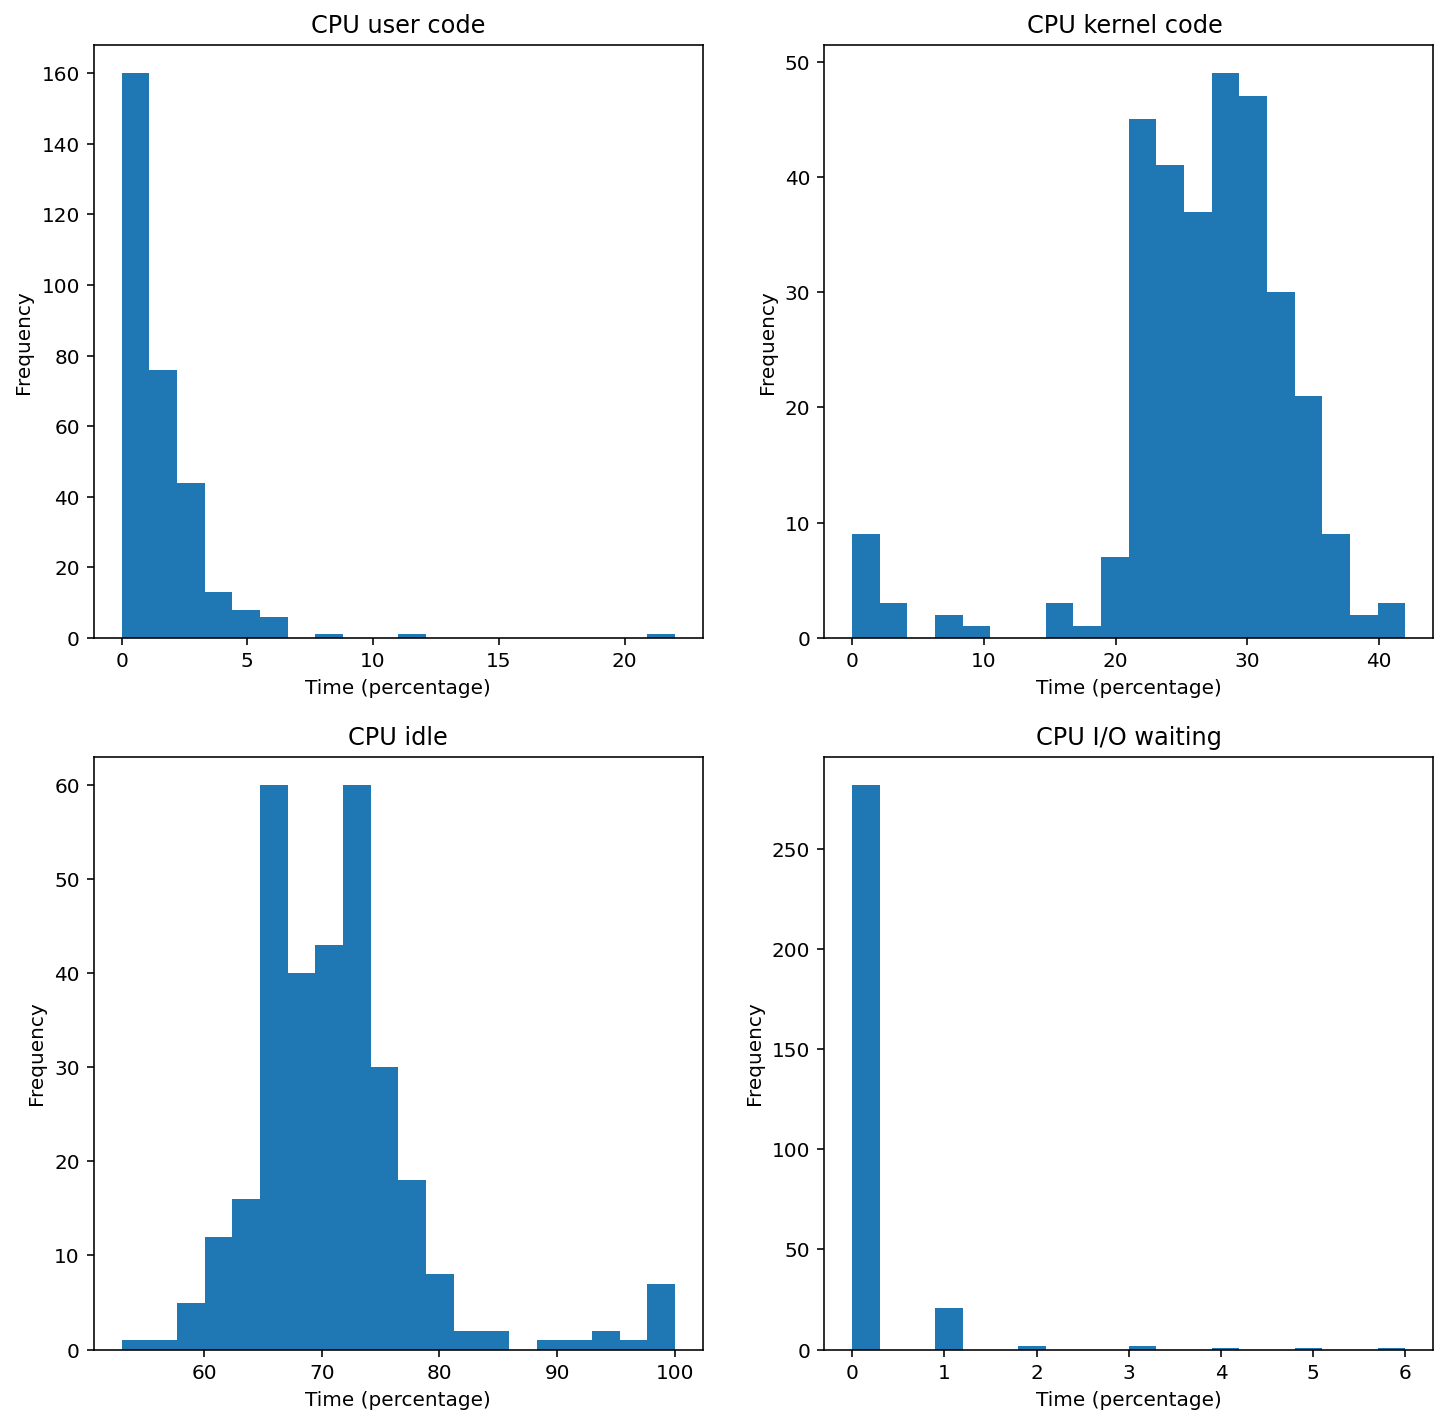

In [47]:
fig = plt.figure(figsize=(12,12))

ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)

df_low.cpu_us.plot.hist(bins=20, ax=ax0)
df_low.cpu_sy.plot.hist(bins=20, ax=ax1)
df_low.cpu_id.plot.hist(bins=20, ax=ax2)
df_low.cpu_wa.plot.hist(bins=20, ax=ax3)

ax0.set_title('CPU user code')
ax0.set_xlabel('Time (percentage)')

ax1.set_title('CPU kernel code ')
ax1.set_xlabel('Time (percentage)')

ax2.set_title('CPU idle')
ax2.set_xlabel('Time (percentage)')

ax3.set_title('CPU I/O waiting')
ax3.set_xlabel('Time (percentage)')

plt.show()

## PCA

### Preprocessing

#### Remove constant components

In [48]:
df_const = df_low.loc[:,df_low.columns[df_low.nunique() == 1]]
df_const.head()

,procs_b,memory_swpd,cpu_st
0,0,270080,0
1,0,270080,0
2,0,270080,0
3,0,270080,0
4,0,270080,0


In [49]:
df_low_pre = df_low.loc[:,df_low.columns[df_low.nunique() != 1]]
df_low_pre.head()

,procs_r,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,4,944412,32300,533824,7,41,237,235,379,1449,22,4,73,1
1,0,943648,32300,533932,0,0,0,0,118,1273,12,3,85,0
2,0,943648,32300,533932,0,0,0,0,45,111,0,1,99,0
3,0,943648,32300,533932,0,0,0,0,34,89,0,0,100,0
4,0,943648,32300,533932,0,0,0,0,49,117,1,0,99,0


#### Remove perfectly correlated components

In [59]:
df_corr = df_low_pre.corr()
df_corr

,procs_r,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
procs_r,1.000000,-0.441972,-0.023711,0.012436,0.110801,0.110801,0.100913,-0.000351,0.142614,0.103200,0.029673,0.151647,-0.165064,0.069614
memory_free,-0.441972,1.000000,-0.229801,-0.286534,0.075336,0.075336,0.013852,0.001775,-0.160920,-0.121087,-0.025508,-0.186194,0.205181,-0.112054
memory_buff,-0.023711,-0.229801,1.000000,0.990679,-0.098498,-0.098498,-0.108278,-0.095649,0.152543,-0.085015,-0.128428,0.150148,-0.109516,-0.020927
memory_cache,0.012436,-0.286534,0.990679,1.000000,-0.119051,-0.119051,-0.124197,-0.089341,0.198967,-0.063722,-0.127055,0.196986,-0.157099,-0.021066
swap_si,0.110801,0.075336,-0.098498,-0.119051,1.000000,1.000000,0.973162,0.193687,-0.188810,0.430938,0.612054,-0.180484,0.014190,0.078800
swap_so,0.110801,0.075336,-0.098498,-0.119051,1.000000,1.000000,0.973162,0.193687,-0.188810,0.430938,0.612054,-0.180484,0.014190,0.078800
io_bi,0.100913,0.013852,-0.108278,-0.124197,0.973162,0.973162,1.000000,0.230973,-0.194821,0.489118,0.639158,-0.178880,0.004272,0.094878
io_bo,-0.000351,0.001775,-0.095649,-0.089341,0.193687,0.193687,0.230973,1.000000,-0.005425,0.182287,0.152959,0.005396,-0.059065,0.168241
system_in,0.142614,-0.160920,0.152543,0.198967,-0.188810,-0.188810,-0.194821,-0.005425,1.000000,0.281399,-0.125845,0.945945,-0.906592,-0.088415
system_cs,0.103200,-0.121087,-0.085015,-0.063722,0.430938,0.430938,0.489118,0.182287,0.281399,1.000000,0.660902,0.328058,-0.502643,-0.017409


In [62]:
mask = np.ones(df_corr.shape, dtype='bool')
mask[np.triu_indices(len(df_corr))] = False

corr_comp = (df_corr == 1 & mask).values.nonzero()
corr_comp = [val[0] for val in corr_comp]

df_low_pre.columns[corr_comp]

Index(['swap_so', 'swap_si'], dtype='object')

In [64]:
df_low_pre = df_low_pre.drop(df_low_pre.columns[corr_comp[0]], axis=1)
df_low_pre.head()

,procs_r,memory_free,memory_buff,memory_cache,swap_si,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,1.947711,1.324291,-1.731444,-2.092720,17.578396,17.106630,3.404705,-3.318974,7.575203,10.758925,-3.172621,0.249441,1.385183
1,-0.534469,1.097350,-1.731444,-1.832969,-0.056888,-0.068495,-0.236250,-3.538324,6.233327,5.424205,-3.312404,1.927416,-0.241358
2,-0.534469,1.097350,-1.731444,-1.832969,-0.056888,-0.068495,-0.236250,-3.599675,-2.626102,-0.977458,-3.591969,3.885054,-0.241358
3,-0.534469,1.097350,-1.731444,-1.832969,-0.056888,-0.068495,-0.236250,-3.608920,-2.793836,-0.977458,-3.731752,4.024885,-0.241358
4,-0.534469,1.097350,-1.731444,-1.832969,-0.056888,-0.068495,-0.236250,-3.596314,-2.580356,-0.443986,-3.731752,3.885054,-0.241358


#### Normalize the components

In [65]:
x = df_low_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_low_pre = pd.DataFrame(data=x_scaled, columns=df_low_pre.columns )
df_low_pre.head()

,procs_r,memory_free,memory_buff,memory_cache,swap_si,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,1.947711,1.324291,-1.731444,-2.092720,17.578396,17.106630,3.404705,-3.318974,7.575203,10.758925,-3.172621,0.249441,1.385183
1,-0.534469,1.097350,-1.731444,-1.832969,-0.056888,-0.068495,-0.236250,-3.538324,6.233327,5.424205,-3.312404,1.927416,-0.241358
2,-0.534469,1.097350,-1.731444,-1.832969,-0.056888,-0.068495,-0.236250,-3.599675,-2.626102,-0.977458,-3.591969,3.885054,-0.241358
3,-0.534469,1.097350,-1.731444,-1.832969,-0.056888,-0.068495,-0.236250,-3.608920,-2.793836,-0.977458,-3.731752,4.024885,-0.241358
4,-0.534469,1.097350,-1.731444,-1.832969,-0.056888,-0.068495,-0.236250,-3.596314,-2.580356,-0.443986,-3.731752,3.885054,-0.241358


### Perform PCA

In [67]:
pca = PCA()

princ_comp = pca.fit(df_low_pre.values)

In [68]:
d = pca.transform(df_low_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_low_pca = pd.DataFrame(data=d, columns=c)
df_low_pca.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8,comp 9,comp 10,comp 11,comp 12
0,13.038490,24.152685,5.882404,-1.910834,-1.064193,-0.555199,-5.094139,-1.813761,-0.030407,-0.015282,-0.251895,0.003679,-0.000089
1,5.569873,3.968207,-0.551543,-1.074740,-1.594392,-0.661844,5.992410,3.652070,1.673685,-0.116656,-0.423147,-0.010557,-0.049454
2,6.526751,-3.561239,-0.456562,0.746056,-0.485186,0.460750,-0.402699,-0.312205,-0.076655,0.096296,0.060574,0.052658,-0.003613
3,6.679372,-3.697789,-0.397619,0.781769,-0.489427,0.482830,-0.447632,-0.337230,-0.169531,0.002879,0.071470,0.053601,-0.004462
4,6.666763,-3.323943,-0.380110,0.689041,-0.549208,0.406249,-0.131255,-0.134741,-0.394089,0.006308,0.067906,0.047489,-0.010015


#### Explained variance

In [69]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA.head(10)

,explained variance,explained variance ratio,cumulative explained variance ratio
0,3.371998,0.258548,0.258548
1,3.129715,0.239971,0.498519
2,1.877891,0.143987,0.642506
3,1.336885,0.102506,0.745011
4,1.081631,0.082934,0.827945
5,0.789574,0.060541,0.888486
6,0.683340,0.052395,0.940881
7,0.434309,0.033301,0.974181
8,0.241030,0.018481,0.992662
9,0.067470,0.005173,0.997836


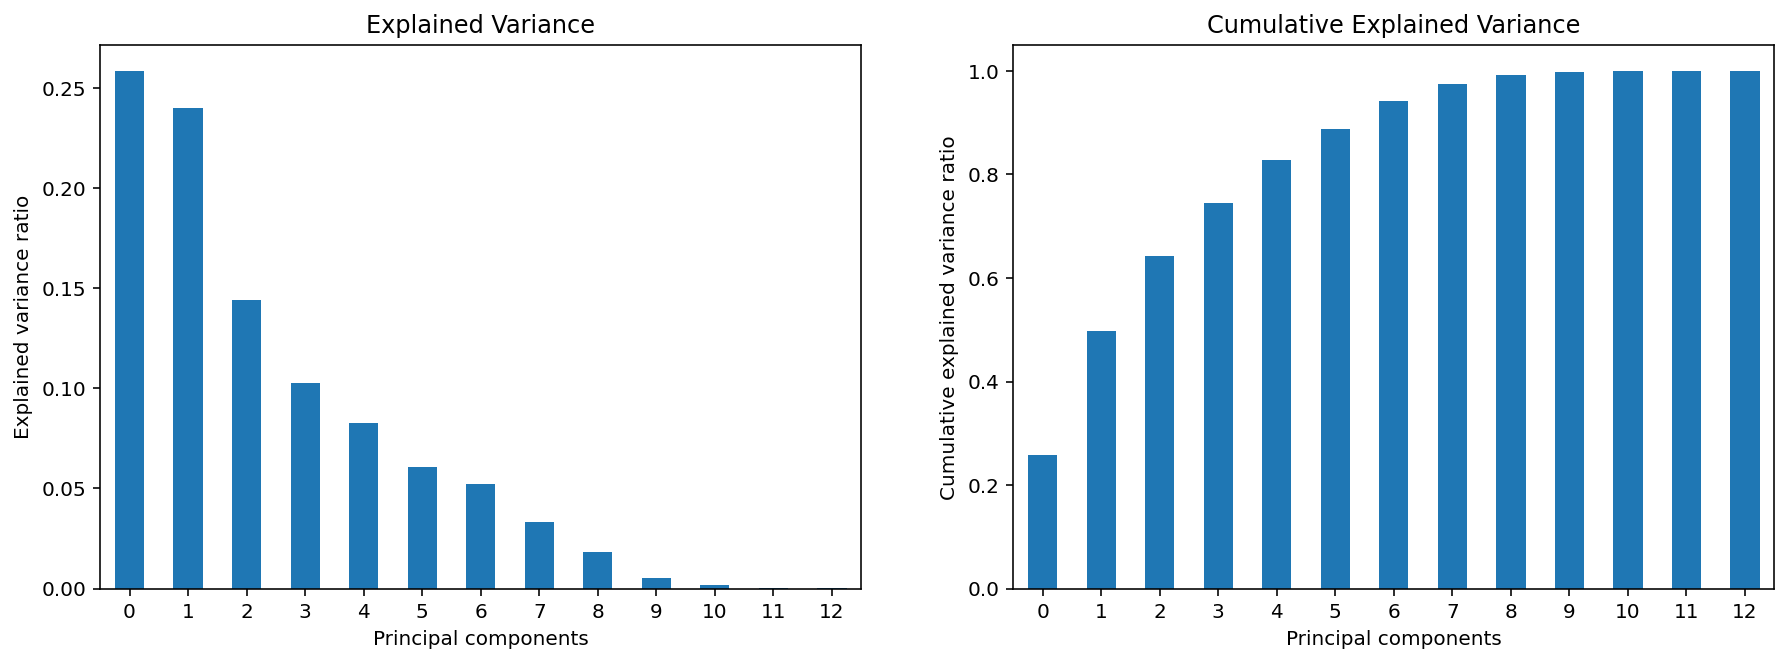

In [70]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.tick_params(labelrotation=0)
ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.tick_params(labelrotation=0)
ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
plt.show()

## Clustering

### Select principal components

In [74]:
dev_tot = df_low_pre.sub(df_low_pre.mean()).pow(2).sum().sum()

nmin_comp = 4
nmax_comp = 7
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 50

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
filepath = './array_dev_lost_low.txt'
if(not os.path.isfile(filepath)):
    print('Creating file',filepath, 'this may take a while...\n')
    
    array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
    
    for i in tqdmn(range(nmin_comp, nmax_comp+1), desc='outer loop'):

        for j in tqdmn(range(1, nmax_cluster+1), desc='inner loop'):
            df_clustering = df_low_pca.iloc[:,0:i]

            # clustering
            clustering = AgglomerativeClustering(n_clusters=j)
            clustering = clustering.fit(df_clustering.values)

            df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

            # deviance PCA
            df_pca = df_low_pca.iloc[:,0:i]
            dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

            # deviance clustering 
            n_elem = df_clustering.groupby('cluster').count().values[:,0]
            centroids = df_clustering.groupby('cluster').mean()

            # intra-cluster deviance
            arr = np.zeros(shape=(j,1))
            for k in range(j):
                elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
                arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
            dev_intra = arr.sum()

            # inter-cluster deviance
            dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
            dev_inter

            # deviance lost
            dev_pca_ratio = dev_pca/dev_tot
            dev_inter_ratio = dev_inter/dev_pca
            dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

            array_dev_lost[j-1][i-n_comp] = dev_lost

#             print(array_dev_lost)
    with open (filepath, 'wb') as fp:
        pickle.dump(array_dev_lost, fp)

else:
    print('File already exists!\n')
    with open (filepath, 'rb') as fp:
        array_dev_lost = pickle.load(fp)
        
        
# array_dev_lost

Creating file ./array_dev_lost_low.txt this may take a while...



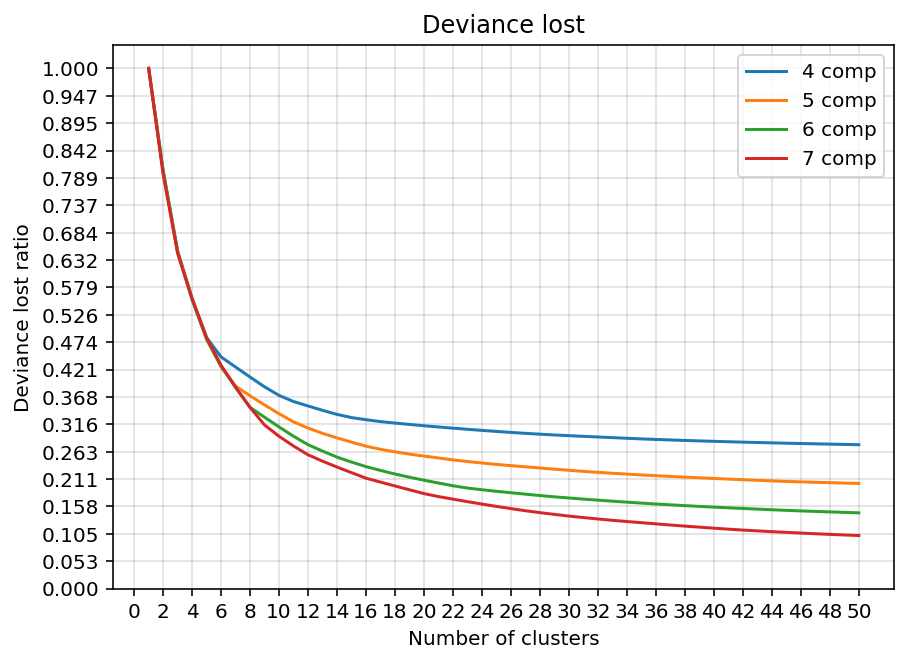

In [75]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0,nmax_cluster+1,2))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)
plt.show()

In [76]:
n_comp = 5
df_low_cl = df_low_pca.iloc[:,0:n_comp]
df_low_cl.head()

,comp 0,comp 1,comp 2,comp 3,comp 4
0,13.038490,24.152685,5.882404,-1.910834,-1.064193
1,5.569873,3.968207,-0.551543,-1.074740,-1.594392
2,6.526751,-3.561239,-0.456562,0.746056,-0.485186
3,6.679372,-3.697789,-0.397619,0.781769,-0.489427
4,6.666763,-3.323943,-0.380110,0.689041,-0.549208


### Perform clustering

In [100]:
n_clusters = 12

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering = clustering.fit(df_low_cl.values)

In [101]:
df_low_clustered = df_low
df_low_clustered.loc[:,'cluster'] = clustering.labels_
df_low_clustered.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st,cluster
0,4,0,270080,944412,32300,533824,7,41,237,235,379,1449,22,4,73,1,0,7
1,0,0,270080,943648,32300,533932,0,0,0,0,118,1273,12,3,85,0,0,11
2,0,0,270080,943648,32300,533932,0,0,0,0,45,111,0,1,99,0,0,3
3,0,0,270080,943648,32300,533932,0,0,0,0,34,89,0,0,100,0,0,3
4,0,0,270080,943648,32300,533932,0,0,0,0,49,117,1,0,99,0,0,3


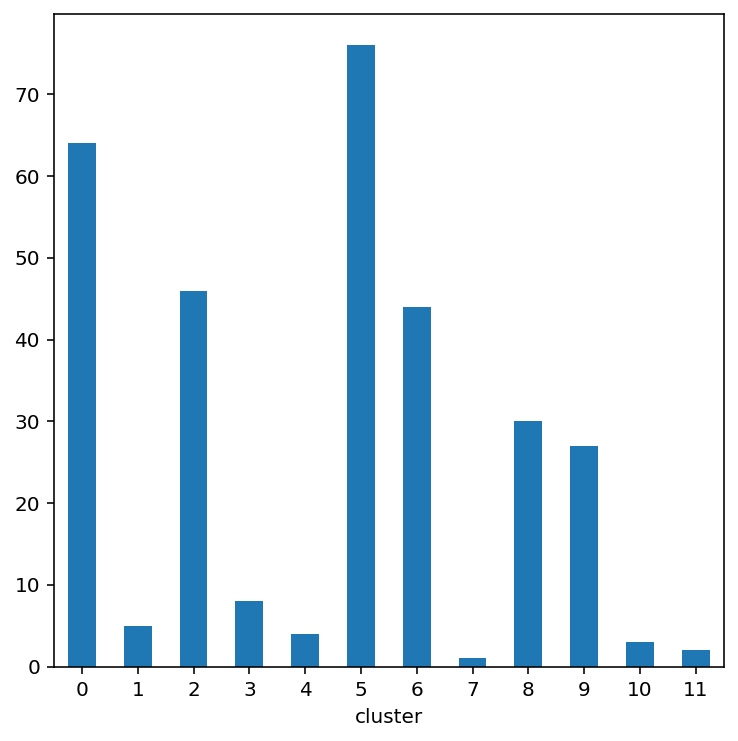

In [102]:
df_low_clustered.groupby(by='cluster').count().procs_r.plot.bar(figsize=(6,6))
plt.xticks(rotation=0)
plt.show()

In [103]:
# pd.set_option('display.max_rows', 50)
df_low_clustered.groupby(by='cluster').mean()
# sns.barplot(x='cluster', columns=df_low_clu.columns, data=df_low_clu)
# plt.show()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
cluster,,,,,,,,,,,,,,,,,
0,0.078125,0.0,270080.0,942909.750000,32375.875000,534138.000000,0.0,0.0,0.0,8.750000,4051.218750,420.046875,1.640625,25.265625,72.859375,0.078125,0.0
1,3.000000,0.0,270080.0,931958.400000,32554.400000,534660.800000,0.0,0.0,11.2,91.200000,4198.400000,609.600000,3.200000,27.600000,66.400000,2.600000,0.0
2,2.173913,0.0,270080.0,935874.608696,32611.826087,534787.913043,0.0,0.0,0.0,11.478261,4154.347826,423.717391,1.565217,25.934783,72.217391,0.173913,0.0
3,0.000000,0.0,270080.0,943691.000000,32304.000000,533934.000000,0.0,0.0,0.0,6.500000,520.375000,248.500000,1.500000,2.500000,95.875000,0.125000,0.0
4,0.000000,0.0,270080.0,941740.000000,32840.000000,535320.000000,0.0,0.0,0.0,9.000000,33.000000,47.250000,0.000000,0.250000,98.500000,1.250000,0.0
5,0.065789,0.0,270080.0,940678.210526,32744.000000,535090.052632,0.0,0.0,0.0,9.105263,4146.644737,422.697368,1.644737,25.315789,72.934211,0.039474,0.0
6,0.636364,0.0,270080.0,940453.818182,32519.818182,534602.090909,0.0,0.0,0.0,11.272727,5420.613636,507.272727,1.931818,33.045455,64.863636,0.045455,0.0
7,4.000000,0.0,270080.0,944412.000000,32300.000000,533824.000000,7.0,41.0,237.0,235.000000,379.000000,1449.000000,22.000000,4.000000,73.000000,1.000000,0.0
8,0.066667,0.0,270080.0,940628.800000,32770.133333,535152.533333,0.0,0.0,0.0,3.333333,5192.566667,526.366667,1.933333,32.200000,65.833333,0.000000,0.0


## Synthetic workload

In [190]:
df_synth = df_low_clustered.groupby('cluster').apply(lambda x: x.sample())
df_synth = df_synth.reset_index(level=0, col_level=2 , drop=True)
df_synth

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st,cluster
307,0,0,265984,474816,40796,963532,0,0,0,36,92,361,2,0,98,0,0,0
30,0,0,265984,476360,40416,962460,0,0,0,16,7149,624,4,33,63,0,0,1
206,0,0,265984,474052,40656,963160,0,0,0,0,6360,562,4,31,65,0,0,2
158,0,0,265984,474060,40592,962980,0,0,0,0,5055,387,2,28,70,0,0,3
252,0,0,265984,474068,40728,963336,0,0,0,0,5404,562,2,33,65,0,0,4
103,11,0,265984,463576,40524,962776,0,0,0,96,5554,889,4,33,61,2,0,5
12,1,0,265984,476864,40400,962400,0,0,0,0,2708,341,1,15,84,0,0,6
0,6,0,265984,476904,40376,962348,3,15,101,109,221,583,9,2,89,1,0,7
294,0,0,265984,473060,40784,963488,0,0,0,0,5354,863,10,28,62,0,0,8
61,0,0,265984,475848,40472,962620,0,0,0,208,5752,447,0,30,67,3,0,9


In [191]:
df_synth.to_csv('df_synth_pre.csv', index=False)

# Low level parameters 2

## Read data

In [105]:
df_low = pd.read_csv('WC_report_server_post.csv', sep='\s+', skiprows=1)
df_low.rename(columns={'r':'procs_r', 'b':'procs_b',
                       'swpd':'memory_swpd', 'free':'memory_free', 'buff':'memory_buff', 'cache':'memory_cache', 
                       'si':'swap_si', 'so':'swap_so', 
                       'bi':'io_bi', 'bo':'io_bo',
                       'in':'system_in', 'cs':'system_cs',
                       'us':'cpu_us', 'sy':'cpu_sy', 'id':'cpu_id', 'wa':'cpu_wa', 'st':'cpu_st'
                      }, inplace=True)
df_low.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
0,6,0,265984,476904,40376,962348,3,15,101,109,221,583,9,2,89,1,0
1,0,0,265984,476896,40376,962352,0,0,0,0,118,438,11,0,89,0,0
2,0,0,265984,476896,40376,962352,0,0,0,0,48,110,1,0,99,0,0
3,0,0,265984,476896,40376,962352,0,0,0,0,38,83,0,1,99,0,0
4,0,0,265984,476896,40376,962352,0,0,0,0,152,458,3,1,96,0,0


In [106]:
print('The dataset contains', df_low.shape[1], 'columns and', df_low.shape[0], 'rows')

The dataset contains 17 columns and 310 rows


## Data analysis

In [107]:
df_low.describe()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
count,310.000000,310.0,310.0,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.00000,310.000000,310.000000,310.0
mean,0.135484,0.0,265984.0,474180.954839,40589.767742,962961.058065,0.022581,0.048387,0.338710,12.493548,5605.903226,494.506452,1.858065,29.73871,68.058065,0.267742,0.0
std,0.763889,0.0,0.0,2620.423468,123.408015,346.037640,0.283539,0.851943,5.740177,51.844599,1312.894279,101.324489,1.749484,6.74401,6.827262,1.071516,0.0
min,0.000000,0.0,265984.0,456952.000000,40376.000000,962348.000000,0.000000,0.000000,0.000000,0.000000,21.000000,40.000000,0.000000,0.00000,52.000000,0.000000,0.0
25%,0.000000,0.0,265984.0,474060.000000,40488.000000,962681.000000,0.000000,0.000000,0.000000,0.000000,5394.000000,447.000000,1.000000,28.00000,65.000000,0.000000,0.0
50%,0.000000,0.0,265984.0,474068.000000,40592.000000,962970.000000,0.000000,0.000000,0.000000,0.000000,5808.000000,484.500000,1.500000,31.00000,67.000000,0.000000,0.0
75%,0.000000,0.0,265984.0,475352.000000,40696.000000,963259.000000,0.000000,0.000000,0.000000,0.000000,6233.000000,543.000000,2.000000,33.00000,70.000000,0.000000,0.0
max,11.000000,0.0,265984.0,476904.000000,40796.000000,963532.000000,4.000000,15.000000,101.000000,788.000000,7925.000000,985.000000,11.000000,40.00000,100.000000,9.000000,0.0


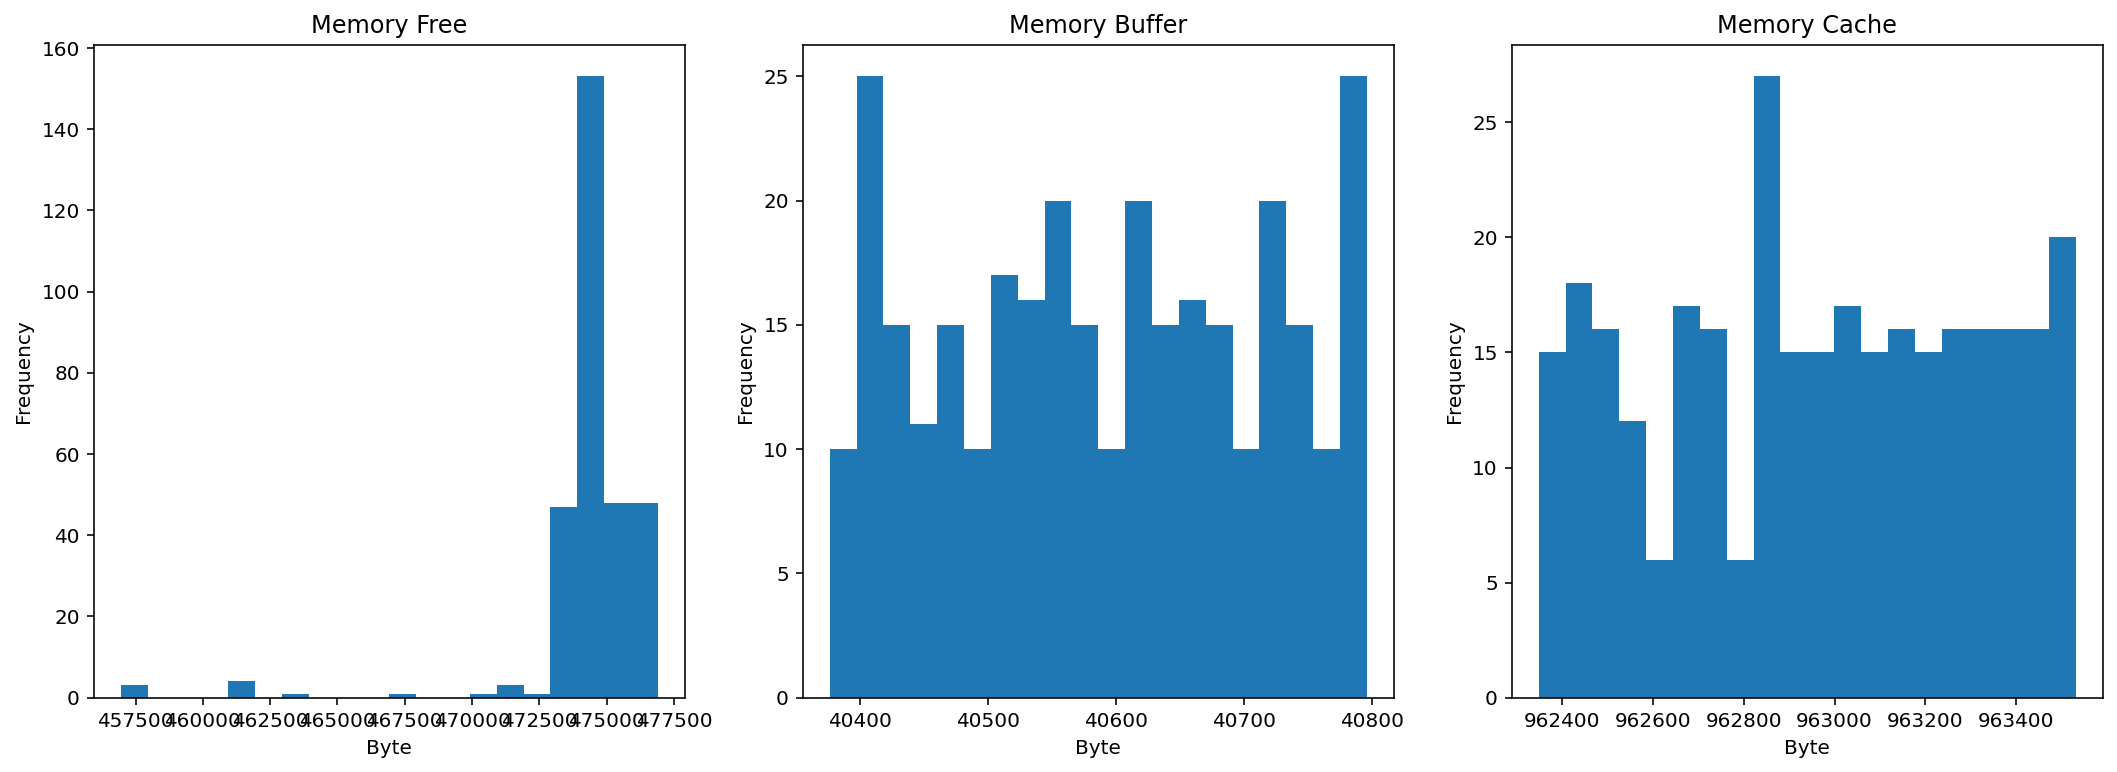

In [108]:
fig = plt.figure(figsize=(18,6))

ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)

df_low.memory_free.plot.hist(bins=20, ax=ax0)
df_low.memory_buff.plot.hist(bins=20, ax=ax1)
df_low.memory_cache.plot.hist(bins=20, ax=ax2)

ax0.set_title('Memory Free')
ax0.set_xlabel('Byte')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed), 5))

ax1.set_title('Memory Buffer')
ax1.set_xlabel('Byte')
# ax1.set_xticks(np.arange(0, max(df_high.Latency), 5))

ax2.set_title('Memory Cache')
ax2.set_xlabel('Byte')

plt.show()

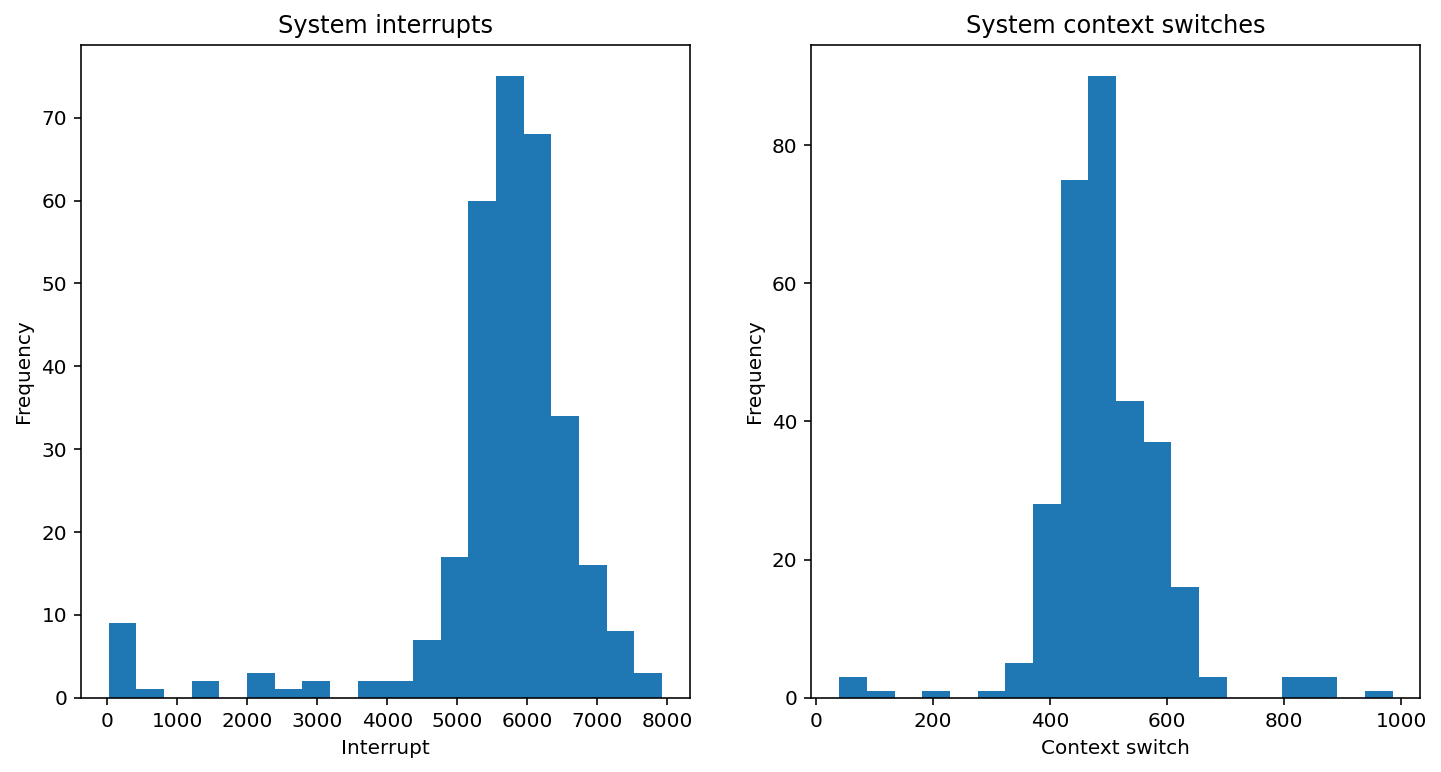

In [109]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_low.system_in.plot.hist(bins=20, ax=ax0)
df_low.system_cs.plot.hist(bins=20, ax=ax1)

ax0.set_title('System interrupts')
ax0.set_xlabel('Interrupt')

ax1.set_title('System context switches')
ax1.set_xlabel('Context switch')

plt.show()

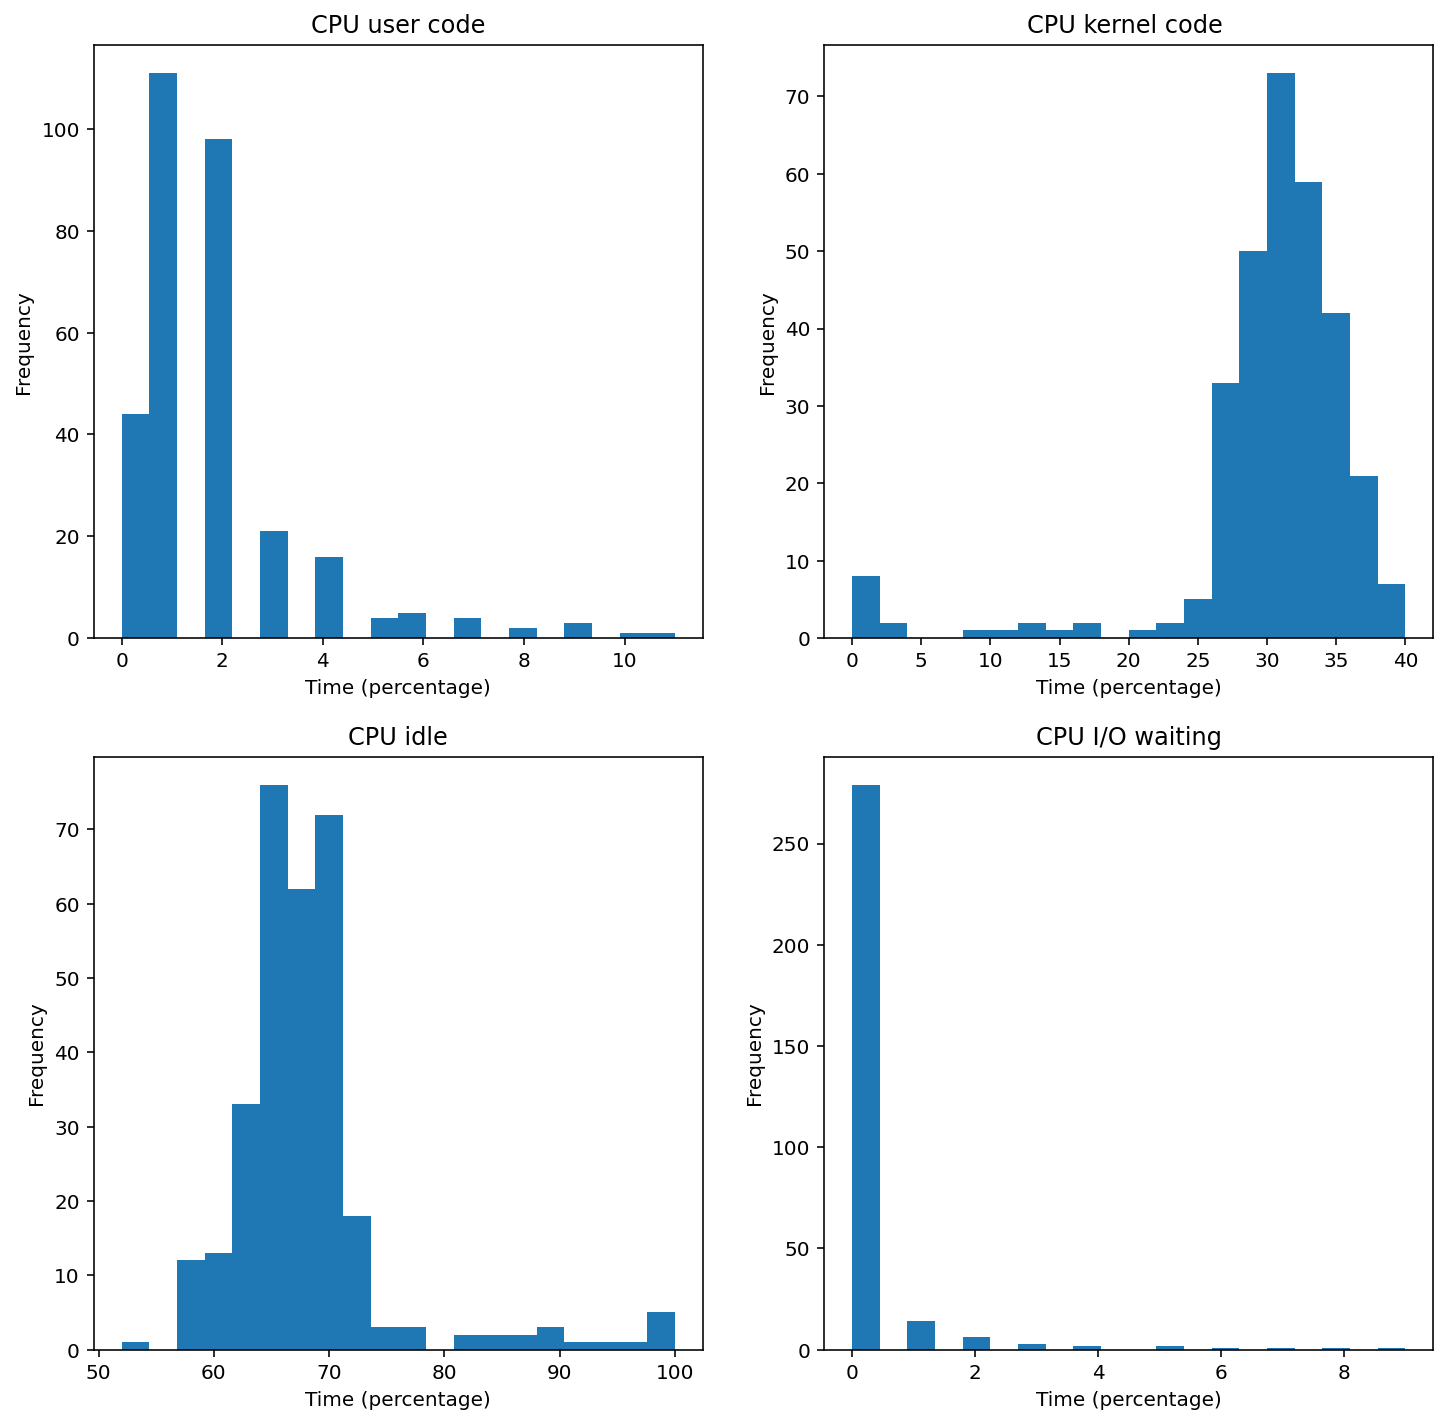

In [110]:
fig = plt.figure(figsize=(12,12))

ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)

df_low.cpu_us.plot.hist(bins=20, ax=ax0)
df_low.cpu_sy.plot.hist(bins=20, ax=ax1)
df_low.cpu_id.plot.hist(bins=20, ax=ax2)
df_low.cpu_wa.plot.hist(bins=20, ax=ax3)

ax0.set_title('CPU user code')
ax0.set_xlabel('Time (percentage)')

ax1.set_title('CPU kernel code ')
ax1.set_xlabel('Time (percentage)')

ax2.set_title('CPU idle')
ax2.set_xlabel('Time (percentage)')

ax3.set_title('CPU I/O waiting')
ax3.set_xlabel('Time (percentage)')

plt.show()

## PCA

### Preprocessing

#### Remove constant components

In [111]:
df_const = df_low.loc[:,df_low.columns[df_low.nunique() == 1]]
df_const.head()

,procs_b,memory_swpd,cpu_st
0,0,265984,0
1,0,265984,0
2,0,265984,0
3,0,265984,0
4,0,265984,0


In [112]:
df_low_pre = df_low.loc[:,df_low.columns[df_low.nunique() != 1]]
df_low_pre.head()

,procs_r,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,6,476904,40376,962348,3,15,101,109,221,583,9,2,89,1
1,0,476896,40376,962352,0,0,0,0,118,438,11,0,89,0
2,0,476896,40376,962352,0,0,0,0,48,110,1,0,99,0
3,0,476896,40376,962352,0,0,0,0,38,83,0,1,99,0
4,0,476896,40376,962352,0,0,0,0,152,458,3,1,96,0


#### Remove perfectly correlated components

In [113]:
df_corr = df_low_pre.corr()
df_corr

,procs_r,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
procs_r,1.000000,-0.150021,-0.167605,-0.171995,0.254779,0.437446,0.436759,0.108623,-0.174393,0.206914,0.188791,-0.127539,0.066125,0.113690
memory_free,-0.150021,1.000000,-0.213498,-0.229000,0.037865,0.059211,0.059285,0.027351,-0.141693,-0.183106,-0.033844,-0.157025,0.163583,0.003689
memory_buff,-0.167605,-0.213498,1.000000,0.998887,-0.071805,-0.098701,-0.099253,-0.045161,0.155612,0.012943,-0.025456,0.113338,-0.108348,0.019610
memory_cache,-0.171995,-0.229000,0.998887,1.000000,-0.073469,-0.100949,-0.101515,-0.048028,0.164928,0.017942,-0.026159,0.122042,-0.116660,0.019273
swap_si,0.254779,0.037865,-0.071805,-0.073469,1.000000,0.598341,0.629584,0.052737,-0.142212,0.250913,0.273968,-0.139068,0.037772,0.225031
swap_so,0.437446,0.059211,-0.098701,-0.100949,0.598341,1.000000,0.999216,0.106066,-0.233706,0.049764,0.232610,-0.234364,0.174780,0.038939
io_bi,0.436759,0.059285,-0.099253,-0.101515,0.629584,0.999216,1.000000,0.105453,-0.233641,0.060649,0.239086,-0.234123,0.171343,0.048873
io_bo,0.108623,0.027351,-0.045161,-0.048028,0.052737,0.106066,0.105453,1.000000,-0.022334,0.092584,-0.066625,-0.022733,0.019494,0.141214
system_in,-0.174393,-0.141693,0.155612,0.164928,-0.142212,-0.233706,-0.233641,-0.022334,1.000000,0.476189,-0.083585,0.929252,-0.886017,-0.076398
system_cs,0.206914,-0.183106,0.012943,0.017942,0.250913,0.049764,0.060649,0.092584,0.476189,1.000000,0.446686,0.525390,-0.643312,0.077231


In [119]:
# mask = np.ones(df_corr.shape, dtype='bool')
# mask[np.triu_indices(len(df_corr))] = False

# corr_comp = (df_corr == 1 & mask).values.nonzero()
# corr_comp = [val[0] for val in corr_comp]

# df_low_pre.columns[corr_comp]

In [118]:
# df_low_pre = df_low_pre.drop(df_low_pre.columns[corr_comp[0]], axis=1)
# df_low_pre.head()

#### Normalize the components

In [120]:
x = df_low_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_low_pre = pd.DataFrame(data=x_scaled, columns=df_low_pre.columns )
df_low_pre.head()

,procs_r,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,7.689596,1.040842,-1.735004,-1.774516,10.517878,17.578396,17.564623,1.864466,-4.108183,0.874780,4.088909,-4.119739,3.072358,0.684490
1,-0.177647,1.037785,-1.735004,-1.762938,-0.079767,-0.056888,-0.059102,-0.241370,-4.186762,-0.558580,5.233952,-4.416778,3.072358,-0.250276
2,-0.177647,1.037785,-1.735004,-1.762938,-0.079767,-0.056888,-0.059102,-0.241370,-4.240166,-3.800938,-0.491260,-4.416778,4.539443,-0.250276
3,-0.177647,1.037785,-1.735004,-1.762938,-0.079767,-0.056888,-0.059102,-0.241370,-4.247795,-4.067840,-1.063781,-4.268258,4.539443,-0.250276
4,-0.177647,1.037785,-1.735004,-1.762938,-0.079767,-0.056888,-0.059102,-0.241370,-4.160823,-0.360875,0.653782,-4.268258,4.099317,-0.250276


### Perform PCA

In [121]:
pca = PCA()

princ_comp = pca.fit(df_low_pre.values)

In [122]:
d = pca.transform(df_low_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_low_pca = pd.DataFrame(data=d, columns=c)
df_low_pca.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8,comp 9,comp 10,comp 11,comp 12,comp 13
0,21.131804,18.411824,4.554392,-2.171792,6.349464,1.044127,-0.556943,-0.067504,-2.417879,-0.810982,0.006381,-0.000045,-0.000024,-6.316301e-14
1,6.195944,-1.639161,-0.978480,-1.665435,-4.791026,-2.165336,2.746241,-0.437696,-1.103708,0.366000,-0.077138,0.022460,0.031718,-2.429653e-15
2,7.160405,-5.198814,-0.836998,-0.186059,-0.805007,-0.062086,-0.080479,-0.456567,0.043542,0.488163,-0.033798,0.012162,0.010479,-8.241533e-16
3,7.118598,-5.450554,-0.861752,-0.036969,-0.381298,0.141100,-0.372739,-0.444469,0.149781,0.498490,0.090276,0.011224,0.007914,-7.106541e-16
4,6.219199,-3.199739,-1.094157,-0.479088,-2.304223,-0.653390,1.069841,-0.462985,0.785082,-1.471820,-0.178581,0.004962,0.002710,-1.318742e-15


#### Explained variance

In [123]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA.head(10)

,explained variance,explained variance ratio,cumulative explained variance ratio
0,3.714798,0.264487,0.264487
1,2.837210,0.202004,0.466491
2,1.963255,0.139780,0.606271
3,1.147540,0.081703,0.687974
4,1.111442,0.079133,0.767106
5,1.026682,0.073098,0.840204
6,0.844488,0.060126,0.900330
7,0.622971,0.044354,0.944685
8,0.440647,0.031373,0.976058
9,0.247347,0.017611,0.993668


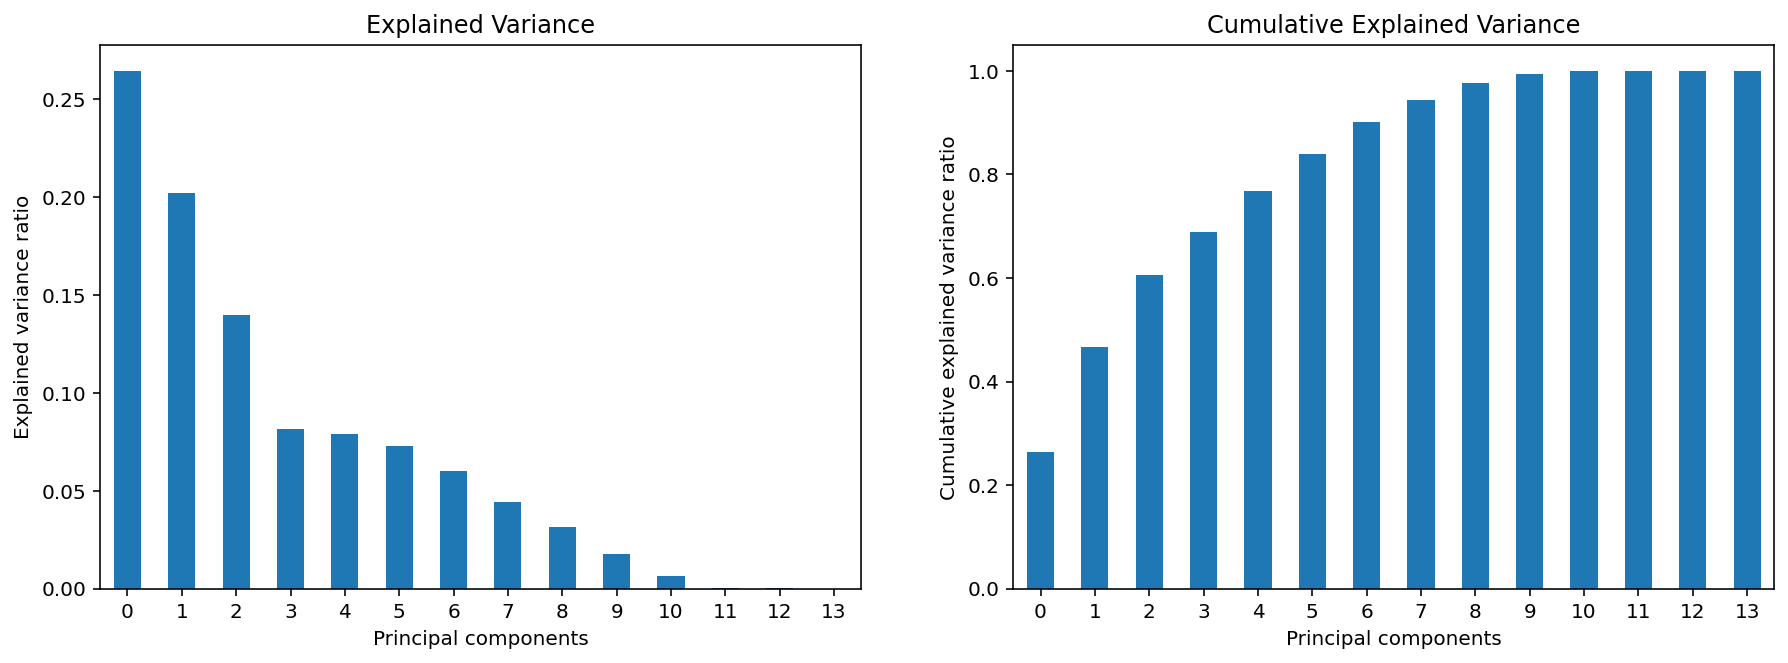

In [124]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.tick_params(labelrotation=0)
ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.tick_params(labelrotation=0)
ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
plt.show()

## Clustering

### Select principal components

In [125]:
dev_tot = df_low_pre.sub(df_low_pre.mean()).pow(2).sum().sum()

nmin_comp = 4
nmax_comp = 7
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 50

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
filepath = './array_dev_lost_low_post.txt'
if(not os.path.isfile(filepath)):
    print('Creating file',filepath, 'this may take a while...\n')
    
    array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
    
    for i in tqdmn(range(nmin_comp, nmax_comp+1), desc='outer loop'):

        for j in tqdmn(range(1, nmax_cluster+1), desc='inner loop'):
            df_clustering = df_low_pca.iloc[:,0:i]

            # clustering
            clustering = AgglomerativeClustering(n_clusters=j)
            clustering = clustering.fit(df_clustering.values)

            df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

            # deviance PCA
            df_pca = df_low_pca.iloc[:,0:i]
            dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

            # deviance clustering 
            n_elem = df_clustering.groupby('cluster').count().values[:,0]
            centroids = df_clustering.groupby('cluster').mean()

            # intra-cluster deviance
            arr = np.zeros(shape=(j,1))
            for k in range(j):
                elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
                arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
            dev_intra = arr.sum()

            # inter-cluster deviance
            dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
            dev_inter

            # deviance lost
            dev_pca_ratio = dev_pca/dev_tot
            dev_inter_ratio = dev_inter/dev_pca
            dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

            array_dev_lost[j-1][i-n_comp] = dev_lost

#             print(array_dev_lost)
    with open (filepath, 'wb') as fp:
        pickle.dump(array_dev_lost, fp)

else:
    print('File already exists!\n')
    with open (filepath, 'rb') as fp:
        array_dev_lost = pickle.load(fp)
        
        
# array_dev_lost

Creating file ./array_dev_lost_low_post.txt this may take a while...



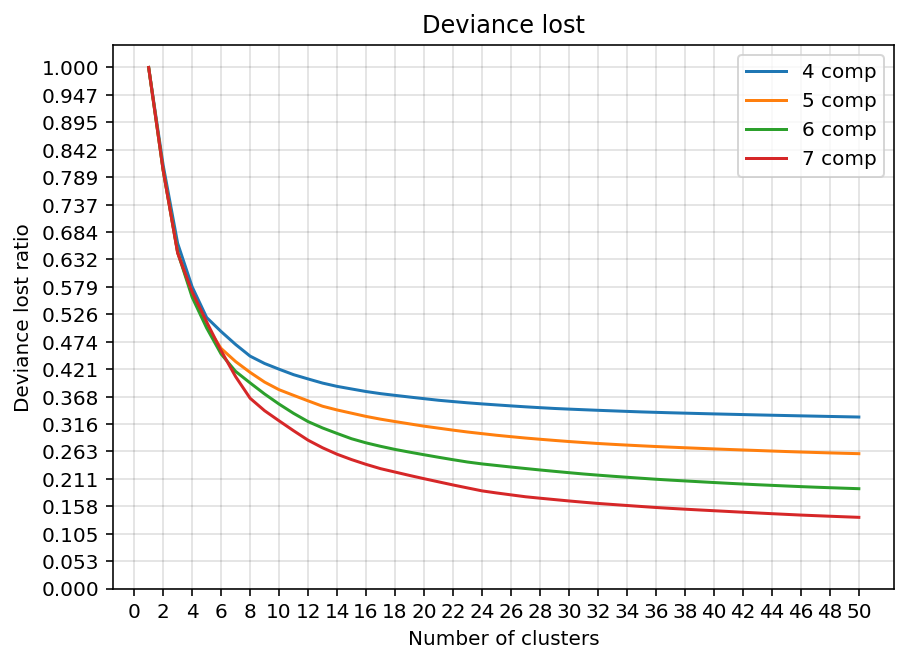

In [126]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0,nmax_cluster+1,2))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)
plt.show()

In [127]:
n_comp = 5
df_low_cl = df_low_pca.iloc[:,0:n_comp]
df_low_cl.head()

,comp 0,comp 1,comp 2,comp 3,comp 4
0,21.131804,18.411824,4.554392,-2.171792,6.349464
1,6.195944,-1.639161,-0.978480,-1.665435,-4.791026
2,7.160405,-5.198814,-0.836998,-0.186059,-0.805007
3,7.118598,-5.450554,-0.861752,-0.036969,-0.381298
4,6.219199,-3.199739,-1.094157,-0.479088,-2.304223


### Perform clustering

In [128]:
n_clusters = 12

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering = clustering.fit(df_low_cl.values)

In [129]:
df_low_clustered = df_low
df_low_clustered.loc[:,'cluster'] = clustering.labels_
df_low_clustered.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st,cluster
0,6,0,265984,476904,40376,962348,3,15,101,109,221,583,9,2,89,1,0,7
1,0,0,265984,476896,40376,962352,0,0,0,0,118,438,11,0,89,0,0,6
2,0,0,265984,476896,40376,962352,0,0,0,0,48,110,1,0,99,0,0,0
3,0,0,265984,476896,40376,962352,0,0,0,0,38,83,0,1,99,0,0,0
4,0,0,265984,476896,40376,962352,0,0,0,0,152,458,3,1,96,0,0,6


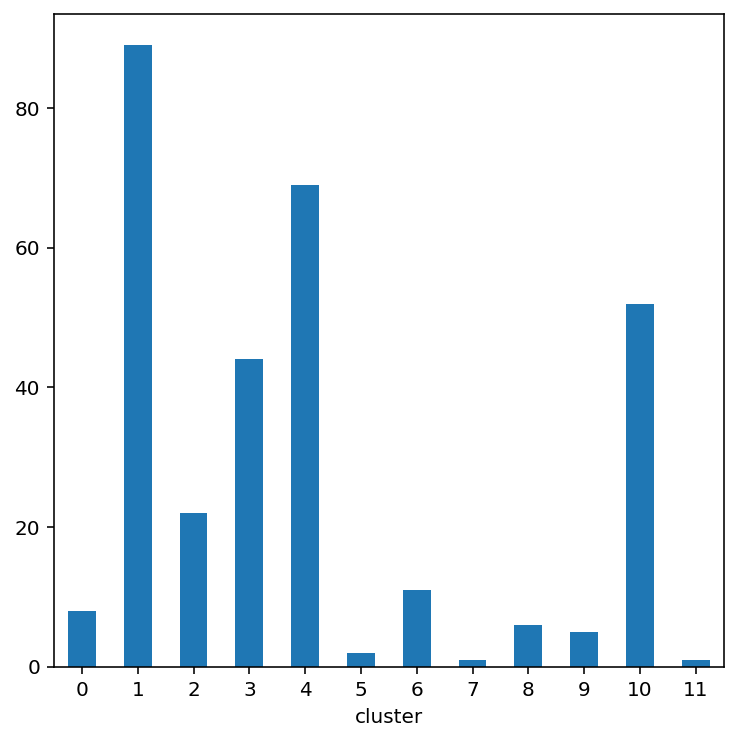

In [130]:
df_low_clustered.groupby(by='cluster').count().procs_r.plot.bar(figsize=(6,6))
plt.xticks(rotation=0)
plt.show()

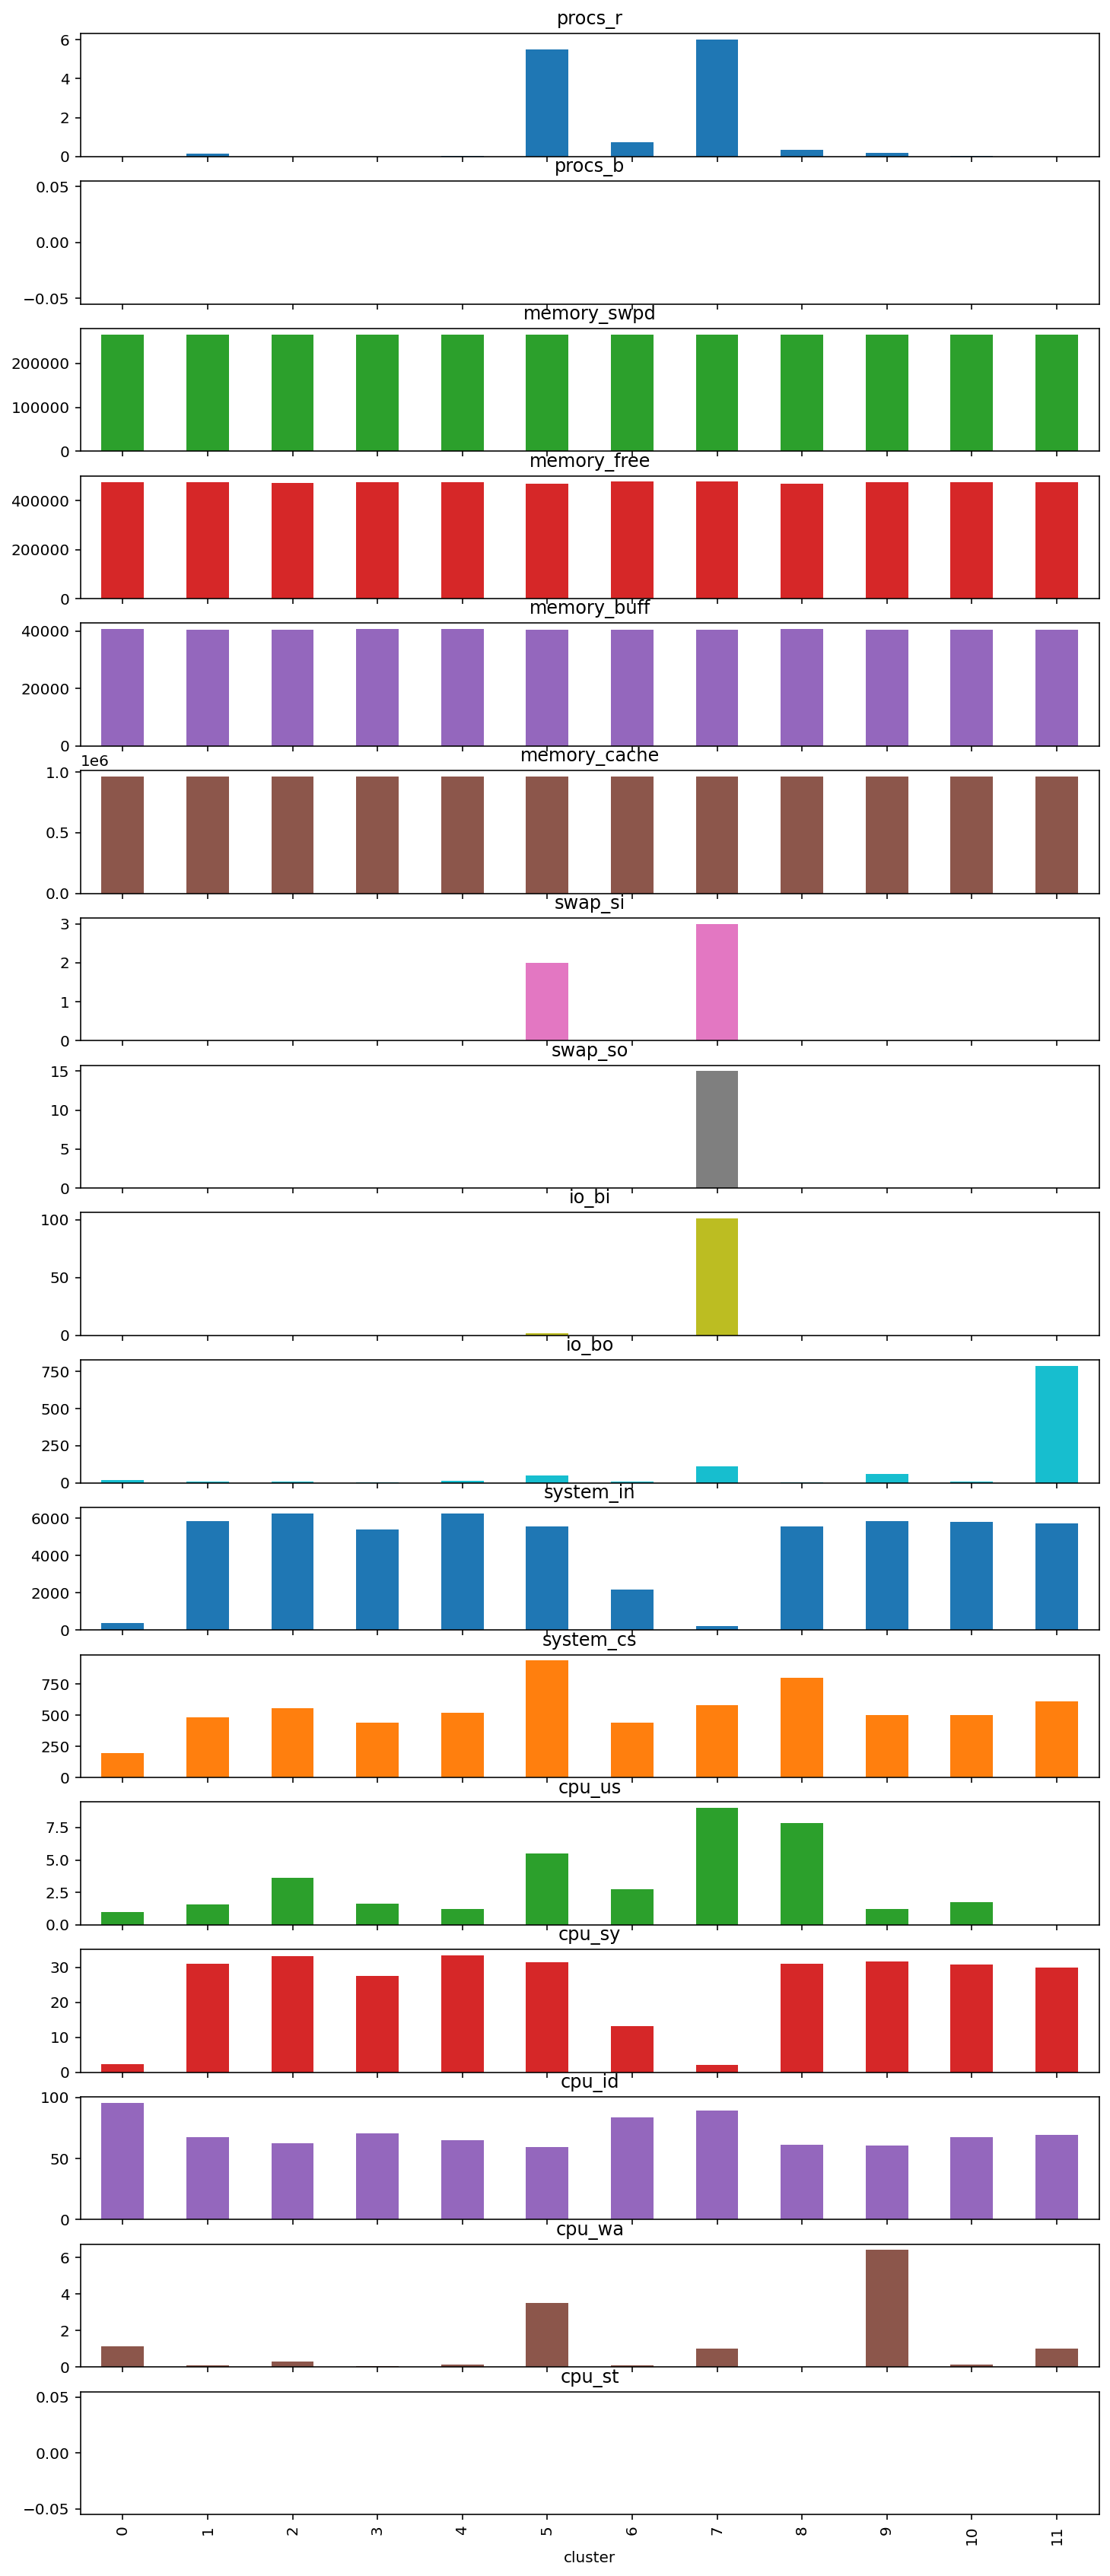

In [173]:
# pd.set_option('display.max_rows', 50)
df_low_clustered.groupby(by='cluster').mean().plot(kind='bar', subplots=True, figsize=(12,30), legend=False)
# sns.barplot(x='cluster', columns=df_low_clu.columns, data=df_low_clu)
plt.show()

## Synthetic workload

In [188]:
df_synth_post = df_low_clustered.groupby('cluster').apply(lambda x: x.sample())
df_synth_post = df_synth_post.reset_index(level=0, col_level=2 , drop=True)
df_synth_post

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st,cluster
305,0,0,265984,474816,40788,963532,0,0,0,0,2315,396,1,13,86,0,0,0
33,0,0,265984,476360,40416,962468,0,0,0,0,7744,535,3,33,64,0,0,1
261,0,0,265984,474068,40736,963368,0,0,0,0,5425,549,6,31,63,0,0,2
278,0,0,265984,473816,40760,963432,0,0,0,0,5626,447,2,26,71,0,0,3
189,0,0,265984,474068,40636,963096,0,0,0,132,6078,544,1,36,63,0,0,4
103,11,0,265984,463576,40524,962776,0,0,0,96,5554,889,4,33,61,2,0,5
7,1,0,265984,476864,40392,962392,0,0,0,0,1419,610,4,13,83,0,0,6
0,6,0,265984,476904,40376,962348,3,15,101,109,221,583,9,2,89,1,0,7
104,0,0,265984,456952,40524,962828,0,0,0,0,5084,807,4,30,66,0,0,8
61,0,0,265984,475848,40472,962620,0,0,0,208,5752,447,0,30,67,3,0,9


In [189]:
df_synth_post.to_csv('df_synth_post.csv', index=False)

# Hypothesis test

In [194]:
df_synth.reset_index(inplace=True, drop=True)
df_synth_post.reset_index(inplace=True, drop=True)

df_synth_sub = df_synth.sub(df_synth_post)
df_synth_sub

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st,cluster
0,0,0,0,0,8,0,0,0,0,36,-2223,-35,1,-13,12,0,0,0
1,0,0,0,0,0,-8,0,0,0,16,-595,89,1,0,-1,0,0,0
2,0,0,0,-16,-80,-208,0,0,0,0,935,13,-2,0,2,0,0,0
3,0,0,0,244,-168,-452,0,0,0,0,-571,-60,0,2,-1,0,0,0
4,0,0,0,0,92,240,0,0,0,-132,-674,18,1,-3,2,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,8,8,0,0,0,0,1289,-269,-3,2,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,16108,260,660,0,0,0,0,270,56,6,-2,-4,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [195]:
df_synth_sub.to_csv('df_synth_sub.csv', index=False)